# AI-Lab

Created by Noam Etten, Luiza Zinca, Mariam Alavidze, Gustaf Cramer, Caspar Lehmkühler

# 1. Introduction

This report aims to examine the RNA sequencing data of breast cancer cells and determine whether they can survive in low-oxygen environments (Hypoxia) or require more oxygen (Normoxia). In order to achieve this goal, we are creating a binary classifier that can identify specific genes in cancer cells and their corresponding ability to survive in high or low-oxygen environments. By analyzing this data, medical practitioners can gain insight into whether the cancer cells found in their patients can survive independently or if they require a direct supply of oxygen.

# 2. Setting up the Project Enviorment

### Understanding the Data



### Improting Libraries and setting up tools

In [77]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kurtosis, skew
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pickle
from warnings import simplefilter

%matplotlib inline     
sns.set(color_codes=True)


path = "G:/My Drive/6. BAI/4. Semester/AI Lab/"

## 3. The Data


The first order of business is to understand and explore the data set given to us. We are working with two sets of sequenced RNA data collected using smart- and drop-sequencing techniques. The cell types are MCF7 and HCC1806. We will begin by exploring, cleaning, visualising and understanding the data given to us. This process should give us an idea of the material we are dealing with and allow us to approach the problem in a structured manner. For convenience we will throughout this project refer to the cells as HCC- and MCF-cells.

### 3.1. Data Import 

Let us start by importing all the data and inspecting the data of both the HCC1806 and MCF7 cells of the Smart Sequencing method. We will use the Smart Seq dataset for our EDA and come back to the Drop Seq dataset later on when we are building our classifier.

In [10]:
# Read in the data

# HCC Smart Seq Cell Line Data Sets

hcc_metadata = pd.read_csv(path + "SmartSeq/HCC1806_SmartS_Metadata.tsv", sep='\t',index_col=0)
hcc_unfiltered = pd.read_csv(path + "SmartSeq/HCC1806_SmartS_Unfiltered_Data.txt",delimiter="\ ", index_col=0, engine='python')
hcc_filtered = pd.read_csv(path + "SmartSeq/HCC1806_SmartS_Filtered_Data.txt", delimiter="\ ", index_col=0, engine='python')
hcc_filtered_normalized_test = pd.read_csv(path + "SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt", delimiter="\ ", index_col=0, engine='python')
hcc_filtered_normalized_train = pd.read_csv(path + "SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt", delimiter="\ ", index_col=0, engine='python')

# MCF Smart Seq Cell Line Data Sets

mcf_metadata = pd.read_csv(path + "SmartSeq/MCF7_SmartS_Metadata.tsv", sep='\t',index_col=0)
mcf_unfiltered = pd.read_csv(path + "SmartSeq/MCF7_SmartS_Unfiltered_Data.txt", delimiter="\ ", index_col=0, engine='python')
mcf_filtered = pd.read_csv(path + "SmartSeq/MCF7_SmartS_Filtered_Data.txt", delimiter="\ ", index_col=0, engine='python')
mcf_filtered_normalized_test = pd.read_csv(path + "SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt", delimiter="\ ", index_col=0, engine='python')  
mcf_filtered_normalized_train = pd.read_csv(path + "SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt", delimiter="\ ", index_col=0, engine='python')

# HCC Drop Seq Cell Line Data Sets

hcc_drop_filtered_normalised_test = pd.read_csv(path + "DropSeq/HCC1806_Filtered_Normalised_3000_Data_test_anonim.txt", delimiter="\ ", index_col=0, engine='python')
hcc_drop_filtered_normalised_train = pd.read_csv(path + "DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt", delimiter="\ ", index_col=0, engine='python')

# MCF Drop Seq Cell Line Data Sets

mcf_drop_filtered_normalised_test = pd.read_csv(path + "DropSeq/MCF7_Filtered_Normalised_3000_Data_test_anonim.txt", delimiter="\ ", index_col=0, engine='python')
mcf_drop_filtered_normalised_train = pd.read_csv(path + "DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt", delimiter="\ ", index_col=0, engine='python')


The first step in our data analysis is to examine the metadata which gives us an indication of how the data is stored and which attributes we can get from cell names. This is crucial since it provides us with some context for the rest of the project.

In [11]:
#looking at metadata of the data sets:

def meta_data_analysis(cell_line,var):
    print("Metadata analysis for ", var, " cell line:")
    print()

    print(var+"_metadata shape:", cell_line.shape)
    print(var+"_metadata columns:", [i for i in cell_line.columns])
    # print(var+"_metadata head:")
    # print(cell_line.head())


    print("Check uniuque values in dataframe for each column:")
    for i in cell_line.columns:
        if i != "Cell name":
           print(i, ":", cell_line[i].unique())

    # check how many unique hypoxia and normoxia cells we observed and if there is an inbalance
    n_hypoxia = len(cell_line[cell_line["Condition"] == "Hypo"].index)
    n_normoxia = len(cell_line[cell_line["Condition"] == "Normo"].index)

    print("\nNumber of hypoxia cells:", n_hypoxia)
    print("Number of normoxia cells:", n_normoxia)
    
    print()

meta_data_analysis(hcc_metadata, "HCC")
print("=====================================================================================================")
meta_data_analysis(mcf_metadata, "MCF")

Metadata analysis for  HCC  cell line:

HCC_metadata shape: (243, 8)
HCC_metadata columns: ['Cell Line', 'PCR Plate', 'Pos', 'Condition', 'Hours', 'Cell name', 'PreprocessingTag', 'ProcessingComments']
Check uniuque values in dataframe for each column:
Cell Line : ['HCC1806']
PCR Plate : [1 2 3 4]
Pos : ['A10' 'A12' 'A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'A8' 'A9' 'B11' 'B12' 'B1'
 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B9' 'C10' 'C11' 'C12' 'C1' 'C5' 'C6' 'C7'
 'C8' 'C9' 'D10' 'D12' 'D1' 'D3' 'D5' 'D9' 'E12' 'E1' 'E5' 'E6' 'E7' 'E8'
 'F12' 'F4' 'F5' 'F7' 'F8' 'F9' 'G10' 'G11' 'G12' 'G1' 'G2' 'G3' 'G4' 'G6'
 'G7' 'G8' 'G9' 'H1' 'H2' 'H5' 'H6' 'H9' 'B8' 'C3' 'C4' 'D2' 'D6' 'E10'
 'E11' 'E3' 'E4' 'E9' 'F10' 'F1' 'F2' 'F3' 'F6' 'H10' 'H11' 'H3' 'A11'
 'C2' 'D11' 'D4' 'E2' 'G5' 'H4' 'H7' 'B10']
Condition : ['Normo' 'Hypo']
Hours : [24]
PreprocessingTag : ['Aligned.sortedByCoord.out.bam']
ProcessingComments : ['STAR,FeatureCounts']

Number of hypoxia cells: 126
Number of normoxia cells: 117

Metadata a

In the next stage of our exploratory data analysis, we examined and described the unfiltered datasets for the "HCC" and "MCF" cell lines. This step was crucial in our pipeline because it allowed us to understand the structure of our datasets, which is the foundation for subsequent data cleaning, manipulation, and analysis.

We print the dimensions of the dataframe using the np.shape function. This step gives us an immediate idea of the dataset's size, helping us to understand the computational resources required for further processing and the potential complexity of the data.

Our function then prints the names of the first five columns and rows of the dataframe, to get a better intuition for the dataframe. For instance, in our case the column names give us information about the cell in hand.

By doing this for both the "HCC" and "MCF" datasets, we start to compare their structures and identify any initial discrepancies or similarities. This information might help in our next steps, which includes data cleaning, standardization, or normalization and further exploratory data analysis.

In [12]:
def unfiltered_data_description(cell_line, var):

    print("Data description for", var, "cell line:")
    # Looking at unfiltered data:

    print("Dataframe dimensions:", np.shape(cell_line))

    # Printing the first five columns and rows of the unfiltered data

    print("First Five Columns: ", [i for i in cell_line.columns][:5])
    print("First Five Rows: ", [i for i in cell_line.index][:5])

    # Printing the number of columns and rows of the unfiltered data

    print("Columns: ", cell_line.shape[1])
    print("Rows: ", cell_line.shape[0])
    print()

unfiltered_data_description(hcc_unfiltered, "HCC")
unfiltered_data_description(mcf_unfiltered, "MCF")

Data description for HCC cell line:
Dataframe dimensions: (23396, 243)
First Five Columns:  ['"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam"', '"output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam"', '"output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam"', '"output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam"', '"output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam"']
First Five Rows:  ['"WASH7P"', '"CICP27"', '"DDX11L17"', '"WASH9P"', '"OR4F29"']
Columns:  243
Rows:  23396

Data description for MCF cell line:
Dataframe dimensions: (22934, 383)
First Five Columns:  ['"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam"', '"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam"', '"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam"', '"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam"', '"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam"']
First Five Rows:  ['"WASH7P"', '"MIR685

In [13]:
def gene_symbls(cell_line, var):
    gene_symbls = cell_line.index
    print("Dataframe indexes for "+var+": \n", gene_symbls)
    print()


gene_symbls(hcc_unfiltered, "HCC")
gene_symbls(mcf_unfiltered, "MCF")
    

Dataframe indexes for HCC: 
 Index(['"WASH7P"', '"CICP27"', '"DDX11L17"', '"WASH9P"', '"OR4F29"',
       '"MTND1P23"', '"MTND2P28"', '"MTCO1P12"', '"MTCO2P12"', '"MTATP8P1"',
       ...
       '"MT-TH"', '"MT-TS2"', '"MT-TL2"', '"MT-ND5"', '"MT-ND6"', '"MT-TE"',
       '"MT-CYB"', '"MT-TT"', '"MT-TP"', '"MAFIP"'],
      dtype='object', length=23396)

Dataframe indexes for MCF: 
 Index(['"WASH7P"', '"MIR6859-1"', '"WASH9P"', '"OR4F29"', '"MTND1P23"',
       '"MTND2P28"', '"MTCO1P12"', '"MTCO2P12"', '"MTATP8P1"', '"MTATP6P1"',
       ...
       '"MT-TH"', '"MT-TS2"', '"MT-TL2"', '"MT-ND5"', '"MT-ND6"', '"MT-TE"',
       '"MT-CYB"', '"MT-TT"', '"MT-TP"', '"MAFIP"'],
      dtype='object', length=22934)



### 3.2. Detect and Insert or Remove Missing Values

We now move on to examine the datasets for missing values. These values could potentially skew our results, so it is important to detect them in the initial stages of our analysis.

In [14]:
# Checking for missing values

def check_for_missing_values(cell_line, var):
    print("Missing values for "+ var +": ", cell_line.isnull().values.any())

check_for_missing_values(hcc_unfiltered, "HCC")
check_for_missing_values(mcf_unfiltered, "MCF")

# removing/replacing possible missing values (Not needed since there aren't any)

Missing values for HCC:  False
Missing values for MCF:  False


We can see that the Unfiltered Data Set does not contain any missing values since the value was simply set to 0 if none were detected. 

### 3.3. Data Visualisation

In [15]:
hcc_unfiltered.describe()
mcf_unfiltered.describe()

,"""output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam""","""output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam""","""output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam""","""output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam""","""output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam""","""output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam""","""output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam""","""output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam""","""output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam""","""output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam""",...,"""output.STAR.4_H14_Hypo_S383_Aligned.sortedByCoord.out.bam""","""output.STAR.4_H1_Norm_S355_Aligned.sortedByCoord.out.bam""","""output.STAR.4_H2_Norm_S356_Aligned.sortedByCoord.out.bam""","""output.STAR.4_H3_Norm_S357_Aligned.sortedByCoord.out.bam""","""output.STAR.4_H4_Norm_S358_Aligned.sortedByCoord.out.bam""","""output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam""","""output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam""","""output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam""","""output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam""","""output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam"""
count,22934.000000,22934.000000,22934.000000,22934.000000,22934.000000,22934.000000,22934.000000,22934.000000,22934.000000,22934.000000,...,22934.000000,22934.000000,22934.000000,22934.000000,22934.000000,22934.000000,22934.000000,22934.000000,22934.000000,22934.000000
mean,40.817651,0.012253,86.442400,1.024636,14.531351,56.213613,75.397183,62.767725,67.396747,2.240734,...,17.362562,42.080230,34.692422,32.735284,21.992718,17.439391,49.242784,61.545609,68.289352,62.851400
std,465.709940,0.207726,1036.572689,6.097362,123.800530,503.599145,430.471519,520.167576,459.689019,25.449630,...,193.153757,256.775704,679.960908,300.291051,153.441647,198.179666,359.337479,540.847355,636.892085,785.670341
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17.000000,0.000000,5.000000,0.000000,7.000000,23.000000,39.000000,35.000000,38.000000,1.000000,...,9.000000,30.000000,0.000000,17.000000,12.000000,9.000000,27.000000,30.000000,38.000000,33.000000
max,46744.000000,14.000000,82047.000000,289.000000,10582.000000,46856.000000,29534.000000,50972.000000,36236.000000,1707.000000,...,17800.000000,23355.000000,81952.000000,29540.000000,12149.000000,19285.000000,28021.000000,40708.000000,46261.000000,68790.000000


Following our preliminary dataset description, we moved on to visualize our gene expression data for both "HCC" and "MCF" cell lines. Visualization at this stage allows us to observe the distribution of our data, identify potential outliers, and gain further insights into the characteristics of our data, which can inform subsequent statistical and bioinformatic analyses.

The function generates a violin plot that includes the first 50 genes in the unfiltered dataset. This comprehensive visualization allows us to observe the distribution of a larger number of genes, and can be particularly helpful in identifying broader trends or patterns in our gene expression data.

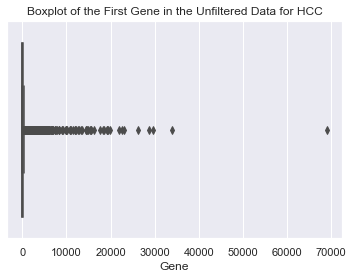

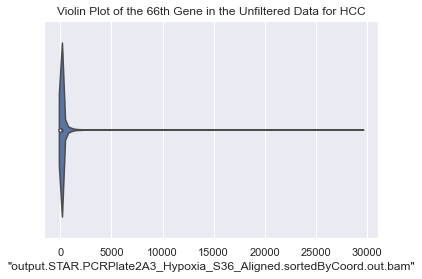

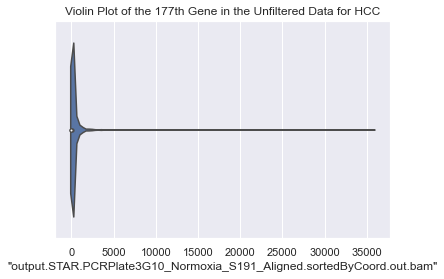

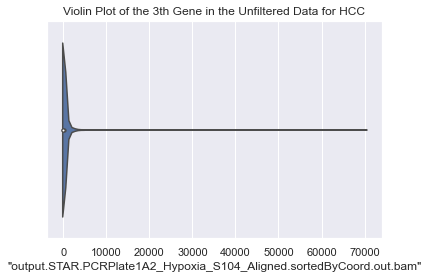

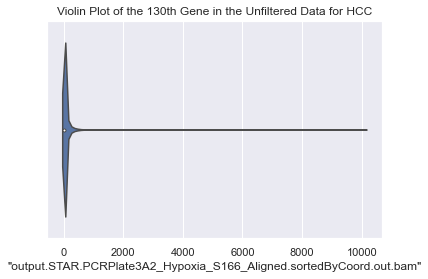

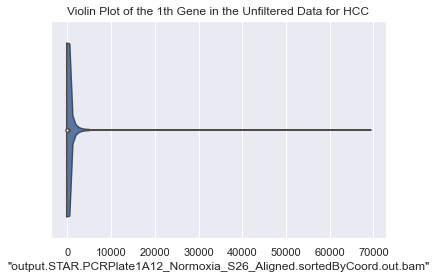

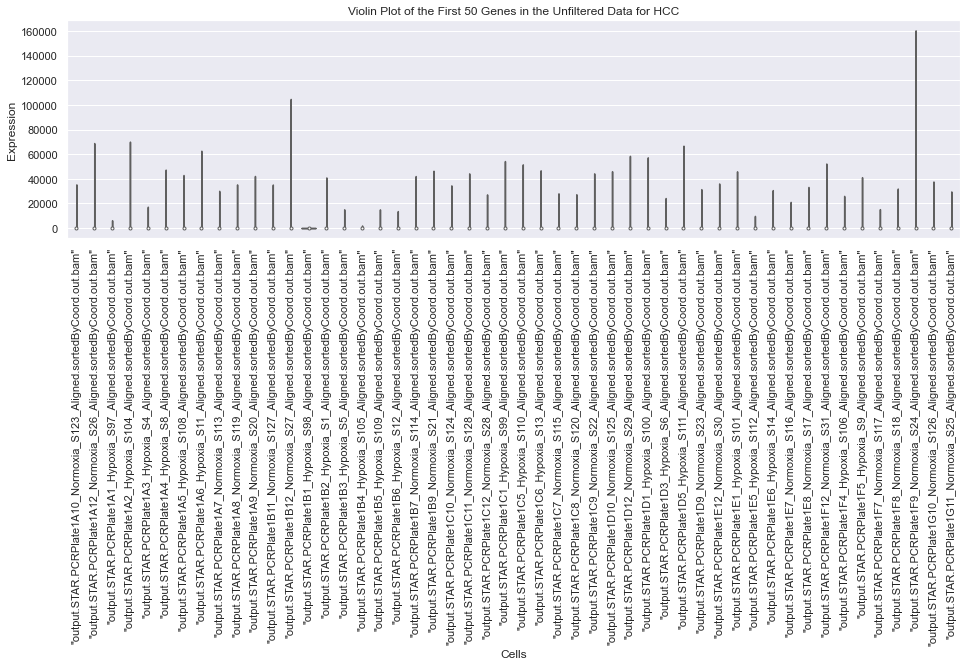

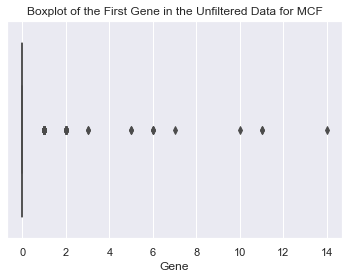

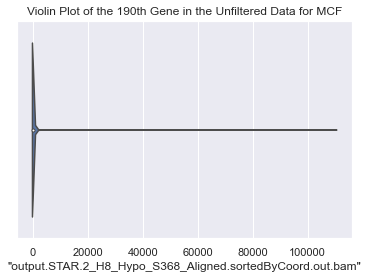

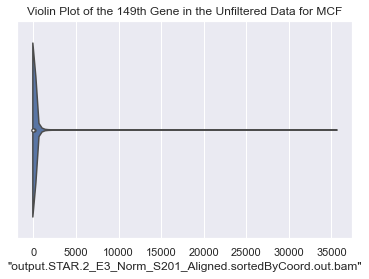

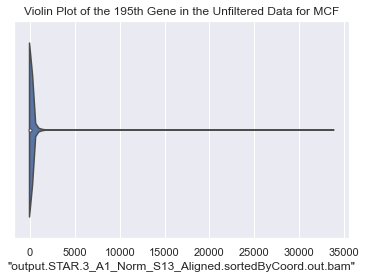

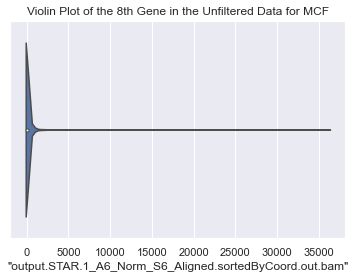

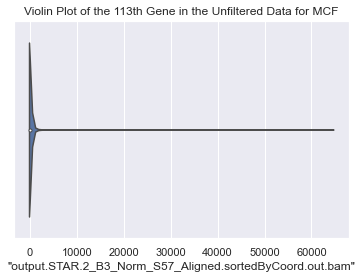

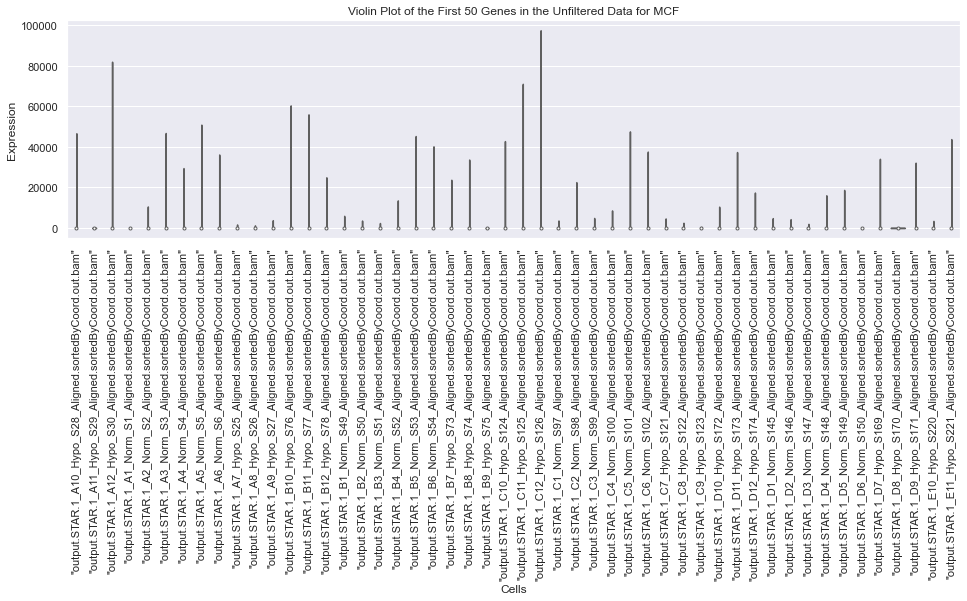

In [16]:
cnames_hcc = list(hcc_unfiltered.columns)
cnames_mcf = list(mcf_unfiltered.columns)

def create_graphs(cell_line, var):

    cnames = list(cell_line.columns)
    cnames[1]
    sns.boxplot(x=cell_line[cnames[1]]).set_title("Boxplot of the First Gene in the Unfiltered Data for "+var)
    plt.xlabel("Gene")
    plt.show()


    # Create A Violin Plot for 10 random genes in the Unfiltered Data
    n = 5
    random_ints = np.random.randint(1, 201, size=5)
    for i in range(n):
        sns.violinplot(x=cell_line[cnames[random_ints[i]]]).set_title("Violin Plot of the "+str(random_ints[i])+"th Gene in the Unfiltered Data for "+var)
        plt.show()

    # Create A Violin Plot of the 50 Genes in the Unfiltered Data

    cell_line_fifty = cell_line.iloc[:, :50]
    np.shape(cell_line_fifty)
    plt.figure(figsize=(16,4))
    plot=sns.violinplot(data=cell_line_fifty,palette="Set3",cut=0).set_title("Violin Plot of the First 50 Genes in the Unfiltered Data for "+var)
    plt.xlabel("Cells")
    plt.ylabel("Expression")
    plt.xticks(rotation=90)
    plt.show()
   


create_graphs(hcc_unfiltered, "HCC")
create_graphs(mcf_unfiltered, "MCF")


These Violin Plots not only give us an idea of median and quartiles of the data, but also of the distribution. Clearly most genes tend to apear rarly in the majority of all cells, which gives us a first indication of the sparsity of the data. However, we need to examine the genes further in order to fully understand how it is distributed and which features are important for Hypoxia and Normoxia cells.

As we can see in the Violin Graphs, some genes occurs more often than others. In order to understand these differences we plotted the 50 most occurring genes in the unfiltered data below.

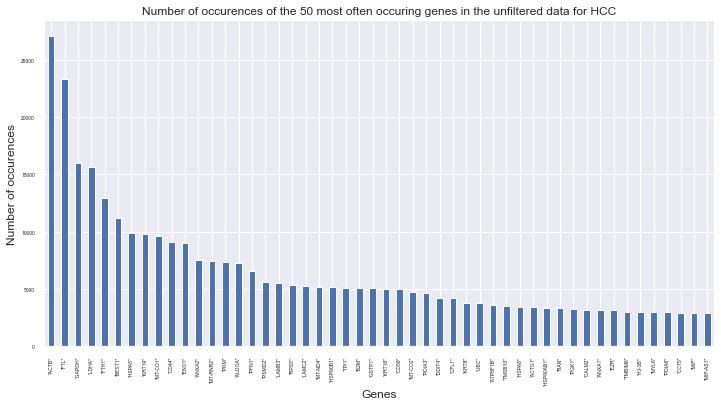

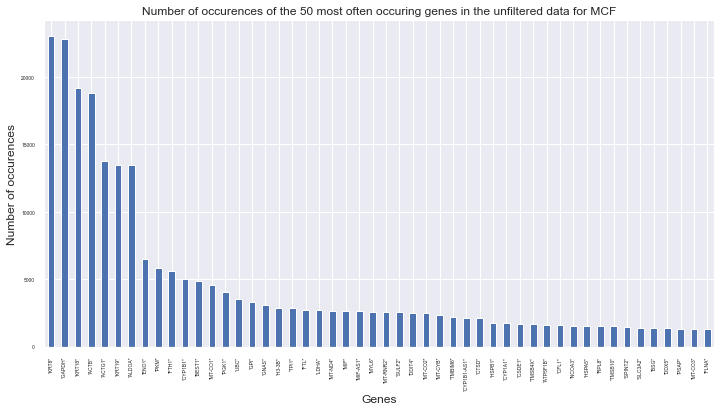

In [17]:
# Plot number of gene occurences in the unfiltered data for the 50 most often occuring genes

def gene_occurences(cell_line, var):
    n = cell_line.shape[1]
    largest = cell_line.sum(axis='columns').nlargest(50)/n
    plt.figure(figsize=(12,6))
    ax = largest.plot.bar(stacked = True, fontsize = 5)
    plt.xlabel('Genes')
    plt.ylabel('Number of occurences')
    plt.title('Number of occurences of the 50 most often occuring genes in the unfiltered data for '+var)
    plt.show()

gene_occurences(hcc_unfiltered, "HCC")
gene_occurences(mcf_unfiltered, "MCF")

While this is interesting to some extent, it does not give us any information on how the occurrences are split between "Normoxia" and "Hypoxia", respectively. We need to split the data in order to understand which genes occurr most often in which specific cell types. 

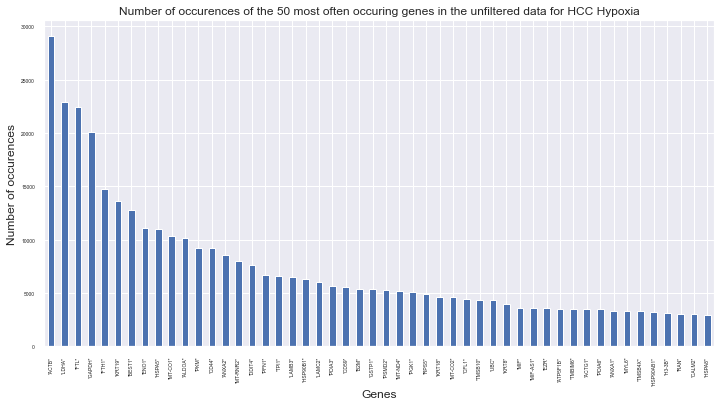

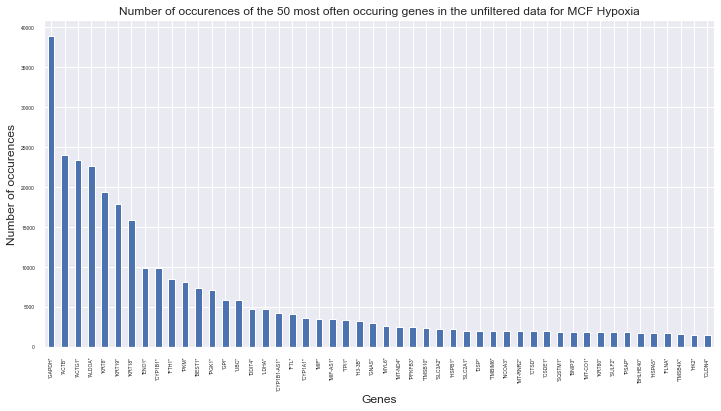

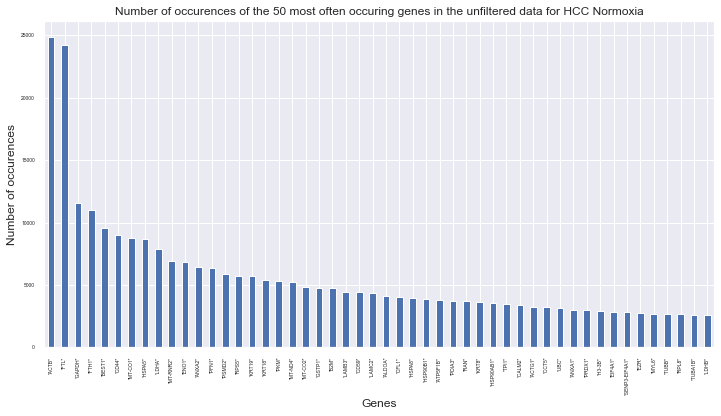

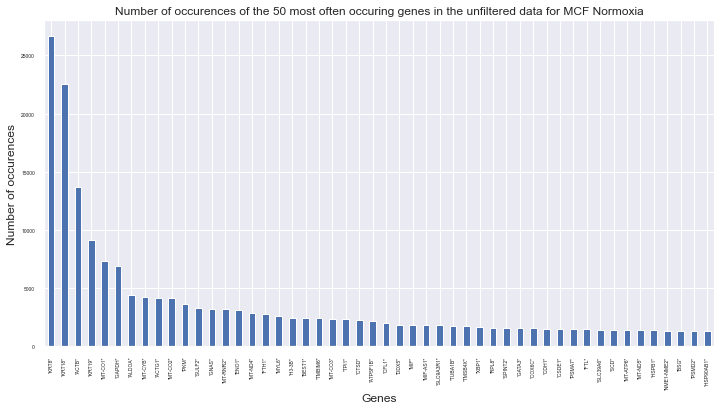

In [20]:
#Split the dataset into "Normoxia" and "Hypoxia" groups

def split_data_by_condition(cell_line, var, condition):
    n_hypoxia = cell_line.loc[:, cell_line.columns.str.contains(condition)].shape[1]
    largest_hypoxia = cell_line.loc[:, cell_line.columns.str.contains(condition)].sum(axis='columns').nlargest(50)/n_hypoxia
    plt.figure(figsize=(12,6))
    plt.title('Number of occurences of the 50 most often occuring genes in the unfiltered data for '+var+" "+condition+"oxia")
    ax = largest_hypoxia.plot.bar(stacked = True, fontsize = 5)
    plt.xlabel('Genes')
    plt.ylabel('Number of occurences')
    plt.show()

split_data_by_condition(hcc_unfiltered, "HCC", "Hyp")
split_data_by_condition(mcf_unfiltered, "MCF", "Hyp")
split_data_by_condition(hcc_unfiltered, "HCC", "Norm")
split_data_by_condition(mcf_unfiltered, "MCF", "Norm")


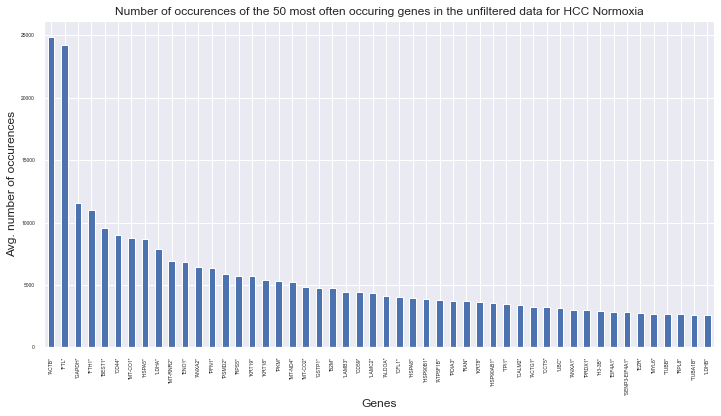

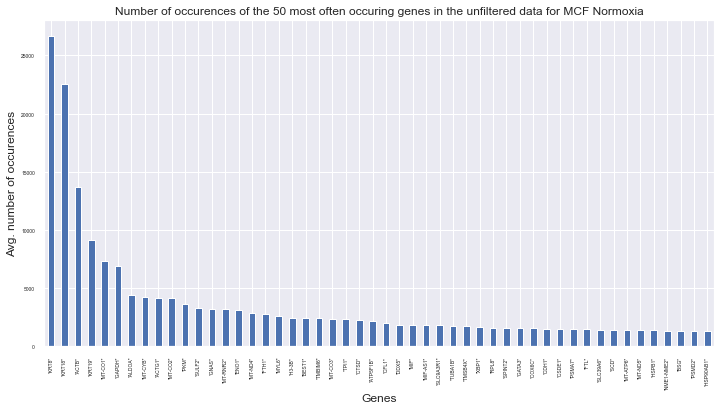

In [12]:
#Split the dataset into "Normoxia" and "Hypoxia" groups

def split_data_normoxia(cell_line, var):
    n_normoxia = cell_line.loc[:, cell_line.columns.str.contains('Norm')].shape[1]
    largest_normoxia = cell_line.loc[:, cell_line.columns.str.contains('Norm')].sum(axis='columns').nlargest(50)/n_normoxia
    plt.figure(figsize=(12,6))
    plt.title('Number of occurences of the 50 most often occuring genes in the unfiltered data for '+var+' Normoxia')
    ax = largest_normoxia.plot.bar(stacked = True, fontsize = 5)
    plt.xlabel('Genes')
    plt.ylabel('Avg. number of occurences')
    plt.show()


split_data_normoxia(hcc_unfiltered, "HCC")
split_data_normoxia(mcf_unfiltered, "MCF")

While this gives us some information on the genes which occur most often, this is not too relevant for our task since these genes will most likely be present in both cell types and can be referred to as "house-keeping" genes. This means that they are crucial to the survival of a cell regardless of its state.

To assess the difference in gene occurrence between hypoxic and normoxic cell types, we initially tally the number of occurrences for each gene in both Hypoxia and Normoxia cells. Subsequently, we calculate the difference by subtracting the sum of gene occurrences in Hypoxia cells from the sum in Normoxia cells. This difference provides insights into the likelihood of specific genes appearing in low- or high-oxygen environments. Thus far, our analysis has focused on identifying genes that exhibit a higher occurrence in either Hypoxic or Normoxic cells.

Cancer cells adapted to survive in low-oxygen conditions (hypoxia) can also survive in normal oxygen conditions (normoxia). We aim to determine which genes are frequently present in hypoxic cells but not normoxic ones. These genes are potentially associated with the enhanced survival of cancer cells in hypoxic environments. We normalised this data by dividing the number of Hypoxia and Normoxia Cells to find the difference in frequency rather than in absolute numbers. 

           Gene Frequency Hypoxia  Gene Frequency Normoxia  \
"LDHA"               22905.341270              7845.384615   
"GAPDH"              20132.682540             11551.418803   
"KRT19"              13634.484127              5701.623932   
"DDIT4"               7587.126984               679.333333   
"ALDOA"              10174.230159              4110.324786   
"ENO1"               11120.253968              6811.888889   
"ACTB"               29122.722222             24894.683761   
"PKM"                 9260.380952              5307.675214   
"PGK1"                5122.206349              1238.923077   
"FTH1"               14759.500000             10980.444444   
"BEST1"              12818.293651              9543.358974   
"TPI1"                6629.039683              3477.948718   
"HSP90B1"             6346.095238              3847.324786   
"HSPA5"              11018.960317              8656.649573   
"ANGPTL4"             2346.523810                60.188034   
"LAMB3" 

<Figure size 864x432 with 0 Axes>

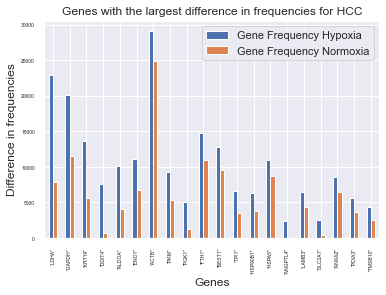

              Gene Frequency Hypoxia  Gene Frequency Normoxia  \
"GAPDH"                 38880.528796              6882.130208   
"ACTG1"                 23399.973822              4165.291667   
"ALDOA"                 22575.340314              4406.187500   
"ACTB"                  23990.272251             13697.984375   
"CYP1B1"                 9849.900524               239.093750   
"KRT19"                 17859.230366              9147.515625   
"KRT8"                  19401.492147             26685.015625   
"ENO1"                   9884.387435              3093.213542   
"KRT18"                 15795.020942             22574.427083   
"PGK1"                   7072.518325              1063.781250   
"FTH1"                   8400.183246              2771.651042   
"MT-CO1"                 1830.534031              7353.911458   
"GPI"                    5839.162304               811.375000   
"BEST1"                  7363.031414              2419.140625   
"UBC"                    

<Figure size 864x432 with 0 Axes>

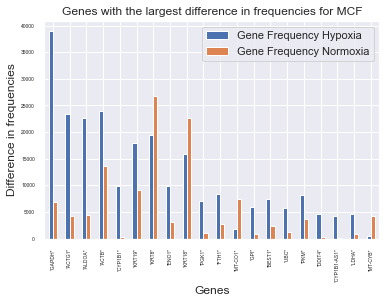

In [31]:
def gene_difference_hypoxia_vs_normoxia(cell_line, var):
    n_normoxia = cell_line.loc[:, cell_line.columns.str.contains('Norm')].shape[1]
    gene_frequency_normoxia = cell_line.loc[:, cell_line.columns.str.contains('Norm')].sum(axis='columns')/n_normoxia
    gene_frequency_normoxia.name = 'Gene Frequency Normoxia'  # Assign a name to the series

    n_hypoxia = cell_line.loc[:, cell_line.columns.str.contains( 'Hypo')].shape[1]
    gene_frequency_hypoxia = cell_line.loc[:, cell_line.columns.str.contains('Hypo')].sum(axis='columns')/n_hypoxia
    gene_frequency_hypoxia.name = 'Gene Frequency Hypoxia'  # Assign a name to the series

    gene_difference_hypoxia_vs_normoxia = pd.merge(gene_frequency_hypoxia, gene_frequency_normoxia, left_index=True, right_index=True)
    gene_difference_hypoxia_vs_normoxia["difference_hypoxia_vs_normoxia"] = abs(gene_difference_hypoxia_vs_normoxia["Gene Frequency Hypoxia"]-gene_difference_hypoxia_vs_normoxia["Gene Frequency Normoxia"])
    print(gene_difference_hypoxia_vs_normoxia.sort_values(by="difference_hypoxia_vs_normoxia", ascending=False).head(50))

    largest_differences = gene_difference_hypoxia_vs_normoxia.nlargest(20, columns="difference_hypoxia_vs_normoxia")
    plt.figure(figsize=(12,6))
    ax = largest_differences.plot.bar(y=["Gene Frequency Hypoxia","Gene Frequency Normoxia"], fontsize = 5)
    plt.xlabel('Genes')
    plt.ylabel('Difference in frequencies')
    plt.title("Genes with the largest difference in frequencies for "+ var)
    plt.show()


gene_difference_hypoxia_vs_normoxia(hcc_unfiltered, "HCC")
gene_difference_hypoxia_vs_normoxia(mcf_unfiltered, "MCF")

Unfortunately, by quickly scanning the data for the largest 50 frequency differences, we can see that our chart, rather than finding genes that occur in one state but not in the other, mainly finds genes that occur in large quantities in both states. Since they are scaled up, the difference is also scaled up. Nevertheless, this graph provides information on genes often occurring in Hypoxic cells; the "DDIT4" Gene, for example, seems predominantly found in Cells in Hypoxic environments.

In order to see whether the data set has any genes that occur in Hypoxia cells but not in Normoxia, or vice versa, we will now transform the data,  setting values to 0 if they are 0 and settting them to 1 otherwise. This way, we can assess the frequency of gene occurrence as an intermediate step. While we do lose some information, this is still an interesting analysis and can help us down the line.

<Figure size 1728x864 with 0 Axes>

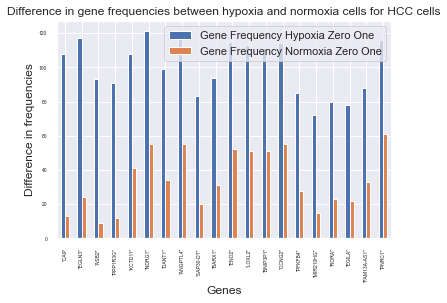

<Figure size 1728x864 with 0 Axes>

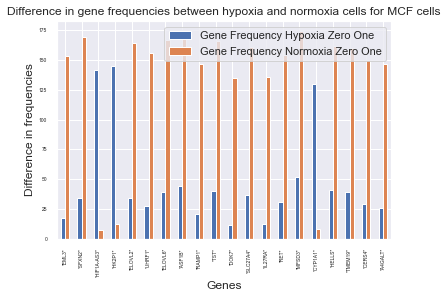

In [34]:
def one_zero(cell_line, var):
    # Transform the Data for Hypoxia cells
    hypoxia = cell_line.loc[:, cell_line.columns.str.contains('Hypo')]
    hypoxia_zero_one = hypoxia.where(hypoxia == 0, other=1)
    gene_frequency_hypoxia_zero_one = hypoxia_zero_one.sum(axis='columns')
    gene_frequency_hypoxia_zero_one.name = 'Gene Frequency Hypoxia Zero One'  # Assign a name to the series

    # print(hypoxia_zero_one.head())

    # Transform the Data for Normoxia cells
    normoxia = cell_line.loc[:, cell_line.columns.str.contains('Norm')]
    normoxia_zero_one = normoxia.where(normoxia == 0, other=1)
    gene_frequency_normoxia_zero_one = normoxia_zero_one.sum(axis='columns')
    gene_frequency_normoxia_zero_one.name = 'Gene Frequency Normoxia Zero One'  # Assign a name to the series

    gene_difference_hypoxia_vs_normoxia_zero_one = pd.merge(gene_frequency_hypoxia_zero_one, gene_frequency_normoxia_zero_one, left_index=True, right_index=True)

    gene_difference_hypoxia_vs_normoxia_zero_one["difference_hypoxia_vs_normoxia_zero_one"] = abs(gene_difference_hypoxia_vs_normoxia_zero_one["Gene Frequency Hypoxia Zero One"]-gene_difference_hypoxia_vs_normoxia_zero_one["Gene Frequency Normoxia Zero One"])


    # Identify the largest differences in gene frequencies between hypoxia and normoxia cells

    largest_differences_zero_one = gene_difference_hypoxia_vs_normoxia_zero_one.nlargest(20, columns="difference_hypoxia_vs_normoxia_zero_one")

    # Plot the largest differences in gene frequencies between hypoxia and normoxia cells

    plt.figure(figsize=(12,6))
    ax = largest_differences_zero_one.plot.bar(y=["Gene Frequency Hypoxia Zero One","Gene Frequency Normoxia Zero One"], fontsize = 5)
    plt.xlabel('Genes')
    plt.ylabel('Difference in frequencies')
    plt.title("Difference in gene frequencies between hypoxia and normoxia cells for " + var + " cells")
    plt.show()

one_zero(hcc_unfiltered, "HCC")
one_zero(mcf_unfiltered, "MCF")


This gives us some interesting information. Both cell types have "Necessary Genes" and genes which they never need. The most interesting point of information, however, is the difference in occurence. It appears that "CA9" in the HCC dataset, for example, is present in almost every Hypoxia cell, but in barely any Normoxia cell. On the other hand, the majority of the large differences in the MCF dataset appears to be genes which occur in Normoxia cells but not in Hypoxia ones. On a very basic level, we can draw from this, that this specific gene is crucial to the survival of the cell in low oxygen environments. When analysing the feature importance in our models later on, we can compare whether these difference in gene expressions also drawn upon by our model

This concludes our basic visualisation of the data. We will now move on to identifying potential outliers.

### 3.4. Outlier Analysis

Now lets move on to cleaning our data in order to run the models on it. We begin by detecting the outliers using Interquartile Range. The IQR method works by identifying the spread of the middle 50% of the dataset and then removing any data point lying outside the 1.5 times IQR above the third quartile (Q3) or below the first quartile (Q1) as an outlier. 

Even without having inspected the outliers we expect that using the IQR will not yield satisfying results, since the sparsity of the data would lead to many deleted entries which would mean a loss of valuable information.

In [46]:
def IQR(cell_line, var):
    # Calculating the IQR for the Unfiltered Data
    
    Q1 = cell_line.quantile(0.25)
    Q3 = cell_line.quantile(0.75)
    IQR = Q3 - Q1

    # Print Q1 values which are not equal to 0

    print(Q3[Q3 == 0].shape)
    print(Q1[Q1 == 0].shape)

    # Count Zero Values in the Unfiltered Data

    sum((cell_line == 0).astype(int).sum(axis=1))

    # Finding the Outliers using the IQR for the Unfiltered Data

    unfiltered_outliers = cell_line[~((cell_line < (Q1 - 1.5 * IQR)) |(cell_line > (Q3 + 1.5 * IQR))).any(axis=1)]
    unfiltered_outliers.shape
    unfiltered_outliers.head()

    # Count Zero Values after removing the Outliers

    sum((unfiltered_outliers == 0).astype(int).sum(axis=1))

IQR(hcc_unfiltered, "HCC")
IQR(mcf_unfiltered, "MCF")

(9,)
(243,)
(38,)
(383,)


These results confirm our previous suspicion about the sparsity of the data. As we can see, that all 243 columns in the HCC and all 383 columns in the MCF- dataset have a lower quartile of 0, which shows the large quantity of zeros in the dataset. The main drawback of using IQR in our case is its vulnerability to the size of the dataset; in very large datasets, it can end up classifying a large portion of the data as outliers, which is exactly what happened in our case.

Therefore, we shifted our approach and adopted the Z-Score method. Z-Scores standardize the dataset by subtracting the mean and dividing by the standard deviation, transforming it into a distribution with a mean of 0 and a standard deviation of 1. Any data point with a Z-Score greater than a certain threshold (commonly ±3) is considered an outlier. One key advantage of the Z-Score method is its scalability for large datasets, unlike the IQR method. It handles large datasets efficiently and allows for standardization, making it easier to compare data points.

To this end we look at Hypoxia and Normoxia separately. We assign to each cell a vector of its genes and first compare the gene vectors of Hypoxia and Normoxia Cells seperately and afterwards we look at both combined. We will then use a clustering method to detect which cells are outlier. This way we might lose some correlation between the Hypoxia and Normoxia, for example, maybe one gene is always "0" in a low-oxygen environment and always "1" in a high-oxygen environment. However, it allows us to detect which cell deviates from the general structure of its label. 

Outlier Ratio Hypoxia HCC: 0.01954037727246823
Outlier Ratio Normoxia HCC: 0.019468957364324094


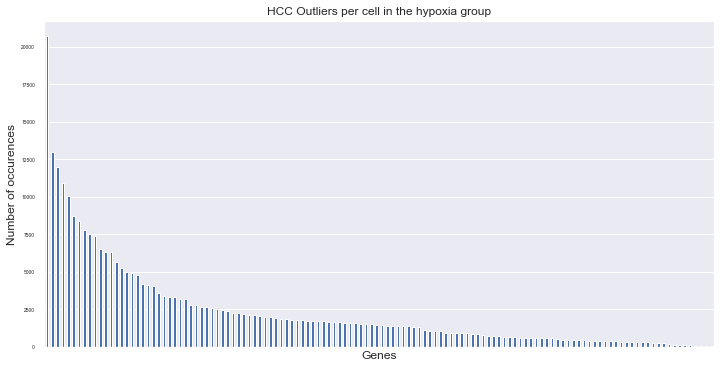

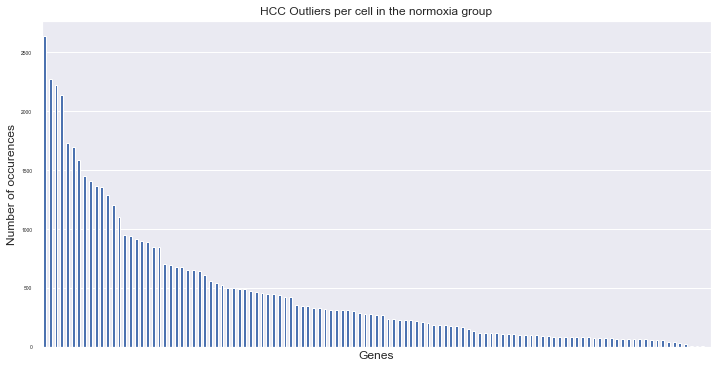

Outlier Ratio Hypoxia MCF: 0.01731214132792621
Outlier Ratio Normoxia MCF: 0.016571102584227202


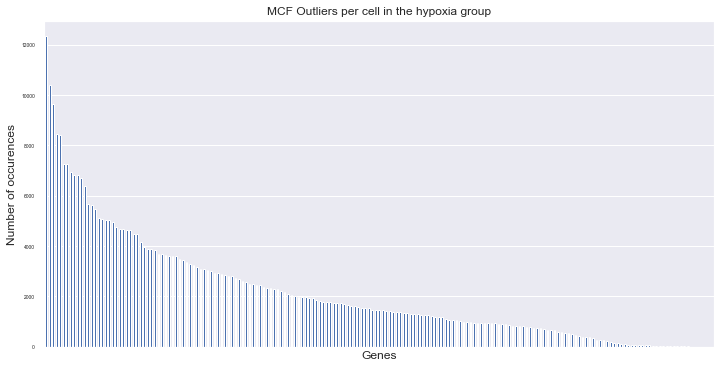

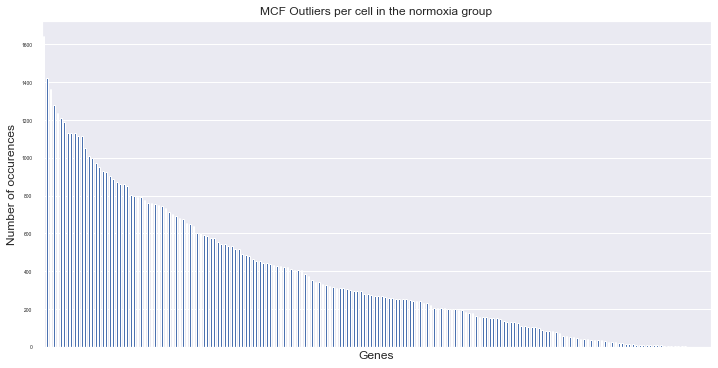

In [47]:
def z_score(cell_line, var):
    # Splitting the unfiltered dataset into hypoxia and normoxia groups to perform the outlier detection on each group separately.
    # we do this to not falsely remove genes that are only expressed in one of the groups and thus could indicate a difference between the groups.

    unfiltered_hypoxia = cell_line.loc[:, cell_line.columns.str.contains('Hypo')]
    unfiltered_normoxia = cell_line.loc[:, cell_line.columns.str.contains('Norm')]


    # Import the stats module from scipy
    from scipy import stats

    # Caluculate the z-score for each gene in the hypoxia group

    unfiltered_hypoxia_zscore = unfiltered_hypoxia.apply(stats.zscore, axis=1)

    # Set values of the z-score which are greater than 3 to 1 and all other values to 0
    unfiltered_hypoxia_zscore = unfiltered_hypoxia_zscore.where(abs(unfiltered_hypoxia_zscore) > 3, other=0)
    
    # Print Outlier Ratio
    print("Outlier Ratio Hypoxia "+var+":", sum((unfiltered_hypoxia_zscore != 0).astype(int).sum(axis=1))/(unfiltered_hypoxia_zscore.shape[0]*unfiltered_hypoxia_zscore.shape[1]))

    # Count non zero values in Hcc_unfiltered_hypoxia_zscore

    sum((unfiltered_hypoxia_zscore != 0).astype(int).sum(axis=1))


    ### REPEAT FOR NORMOXIA


    # Caluculate the z-score for each gene in the normoxia group
    unfiltered_normoxia_zscore = unfiltered_normoxia.apply(stats.zscore, axis=1)

    # Set values of the z-score which are greater than 3 to 1 and all other values to 0
    unfiltered_normoxia_zscore = unfiltered_normoxia_zscore.where(abs(unfiltered_normoxia_zscore) > 3, other=0)
    unfiltered_normoxia_zscore = unfiltered_normoxia_zscore.where(unfiltered_normoxia_zscore == 0, other=1)

    # Summing the outlier genes detected per cell
    unfiltered_hypoxia_zscore_sums = unfiltered_hypoxia_zscore.sum(axis=0).sort_values(ascending=False)
    unfiltered_normoxia_zscore_sums = unfiltered_normoxia_zscore.sum(axis=0).sort_values(ascending=False)

    # Print Outlier Ratio

    print("Outlier Ratio Normoxia "+var+":", sum((unfiltered_normoxia_zscore != 0).astype(int).sum(axis=1))/(unfiltered_normoxia_zscore.shape[0]*unfiltered_normoxia_zscore.shape[1]))

    # Count non zero values in Hcc_unfiltered_normoxia_zscore

    sum((unfiltered_normoxia_zscore != 0).astype(int).sum(axis=1))


    # create a barplot outliers per cell for the hypoxia group

    plt.figure(figsize=(12,6))
    ax = unfiltered_hypoxia_zscore_sums.plot.bar(stacked = True, fontsize = 5)
    plt.xlabel('Genes')
    plt.ylabel('Number of occurences')
    plt.xticks([])
    plt.title(var+' Outliers per cell in the hypoxia group')
    plt.show()

    # create a barplot outliers per cell for the normoxia group

    plt.figure(figsize=(12,6))
    ax = unfiltered_normoxia_zscore_sums.plot.bar(stacked = True, fontsize = 5)
    plt.xlabel('Genes')
    plt.ylabel('Number of occurences')
    plt.xticks([])
    plt.title(var+' Outliers per cell in the normoxia group')
    plt.show()


z_score(hcc_unfiltered, "HCC")
z_score(mcf_unfiltered, "MCF")



This process showed us the cells which have the largest amount of outlier genes. While there are some cells which give us a large number of outlier genes, apart from the first column in the Hypoxia Graph, the outliers seem to be almost normally distributed, making it difficult to identify specific outliers we could remove. This is not an entirely unexpected scenario in gene data analysis, as genes that operate outside the norm often have significant biological meaning.

The normal distribution of outliers suggests the presence of a wide range of variations within the dataset, which are not simply errors or anomalies but rather natural deviations. This characteristic of genetic data – that the 'outliers' may not be spurious but biologically meaningful – highlights a potential limitation of the Z-Score method: it may not distinguish well between biological variability and true outliers.

Since we cannot identify any outliers with certainty, we refrain from deleting any data and instead move on to normalising our dataset. While this process of identifying outliers seems to not have worked, we have gained some valuable insight into the distributions in the dataset. 

### 3.5. Normalising the Data

In order to get a better feel for the actual distribution of the data we will now examine the skewness and kurtosis of the graph. Using these graphs will help us understand whether the data follows a normal distribution.

Skewness measures the asymmetry of the probability distribution of a real-valued random variable about its mean. In simpler terms, it shows whether the data points tend to lean more towards the left (negative skew) or the right (positive skew) of the mean, or if they are symmetrical (zero skew). Depending on the skewness we detect, we can utilise a normalisation technique such as (logarithmic or square root) to achieve a more symmetrical distribution. This will allign our data more closely to the normal distribution and reduce the variance.

Kurtosis works similarly in that it identifies the peaks and tails of a dataset. If for example, a dataset is normally distributed but has high Kurtosis, this gives an indicator for a high number of outliers. 

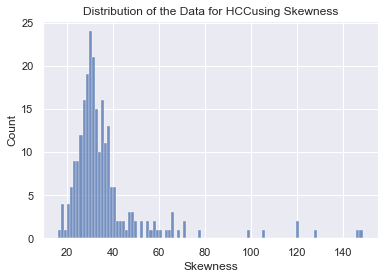

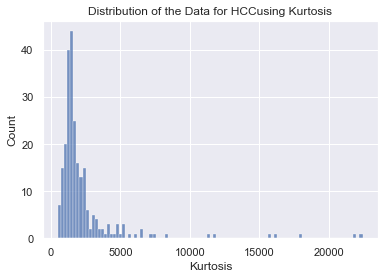

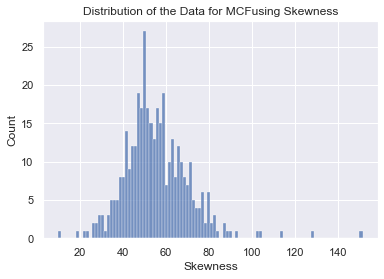

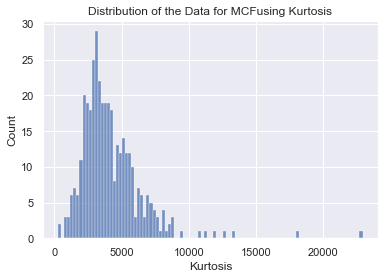

In [48]:
# Detect Distribution of the Data


def distribution(cell_line, var):

    cnames = list(cell_line.columns)
    colN = np.shape(cell_line)[1]
    unfiltered_kurtosis = []
    unfiltered_skewness = []
    for i in range(colN):
        v_df = cell_line[cnames[i]]
        unfiltered_skewness.append(skew(v_df))
        unfiltered_kurtosis.append(kurtosis(v_df))
    
    # Plot Skewness of the Data
    unfiltered_skewness
    sns.histplot(unfiltered_skewness,bins=100)
    plt.title("Distribution of the Data for "+var+ "using Skewness")
    plt.xlabel("Skewness")
    plt.show()

    # PLot Kurtosis of the Data
    unfiltered_kurtosis
    sns.histplot(unfiltered_kurtosis,bins=100)
    plt.title("Distribution of the Data for "+var+ "using Kurtosis")
    plt.xlabel("Kurtosis")
    plt.show()

    print()

distribution(hcc_unfiltered, "HCC")
distribution(mcf_unfiltered, "MCF")

The distributions are highly non-normal with heavy tails. Furthermore, we seem to have a large positive skew. 

There can be many explanations for this:
1. Since this data is sampled from cells, there is biological variability depending on the conditions of the experiment.
2. Gene expression data is often sparse, meaning many genes are not expressed in a given sample. This leads to a distribution with many zeros, which is incompatible with a normal distribution.
3. As mentioned before, gene expressions can have many outliers influencing the data distribution.

Highly non-normal distributions can alter the result of the z-scores, which could have resulted in the non-satisfying results of the outlier analysis above. In order to get better results we have to use a normalising technique - in our case Logarithmic Normalisation.

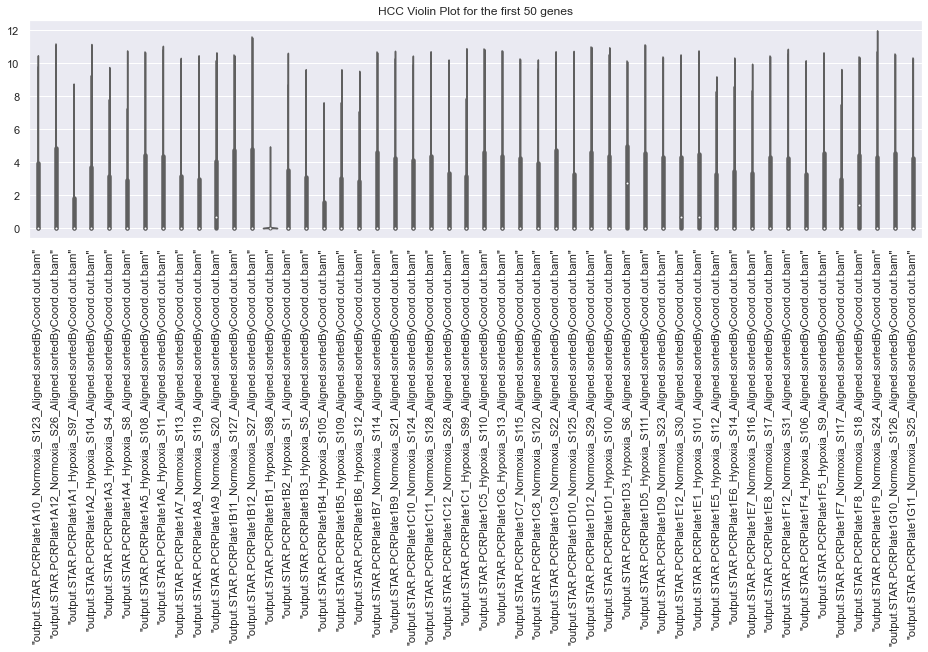

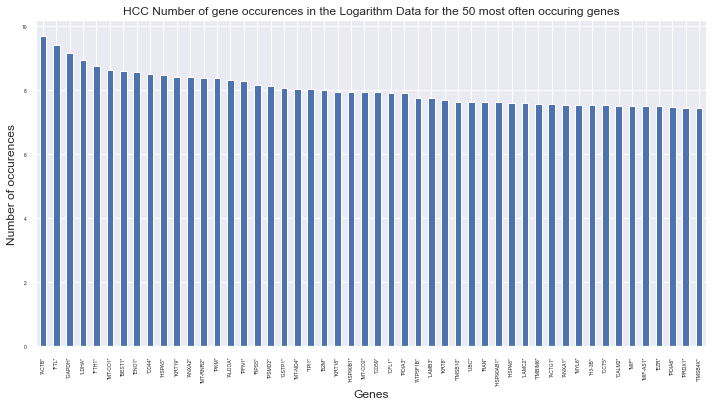

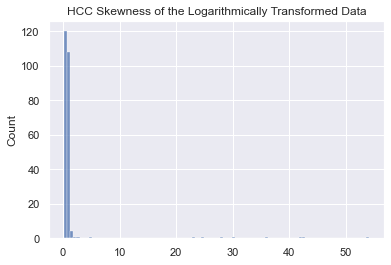

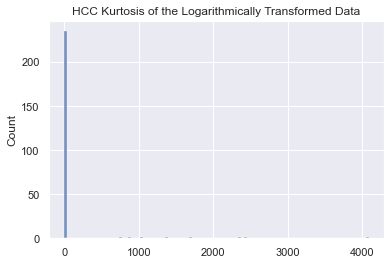

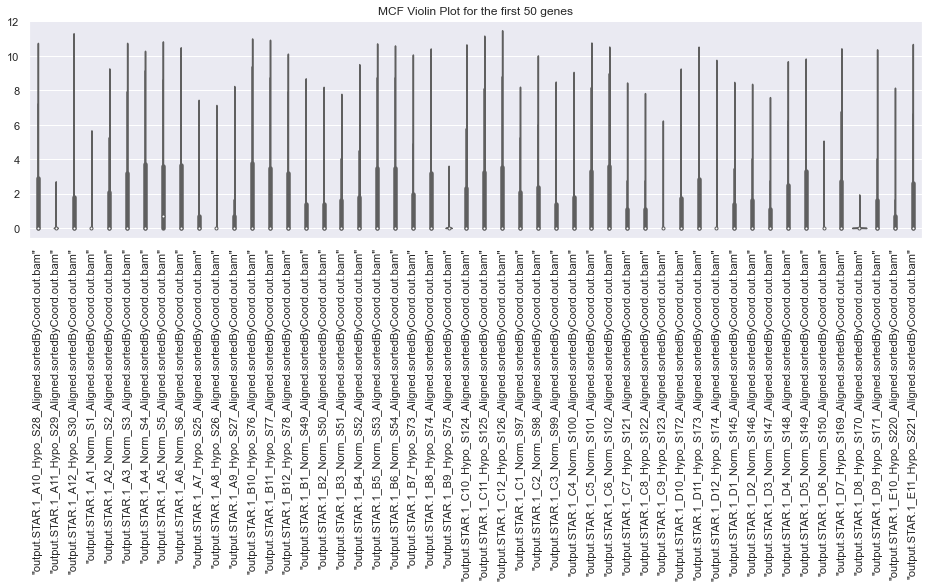

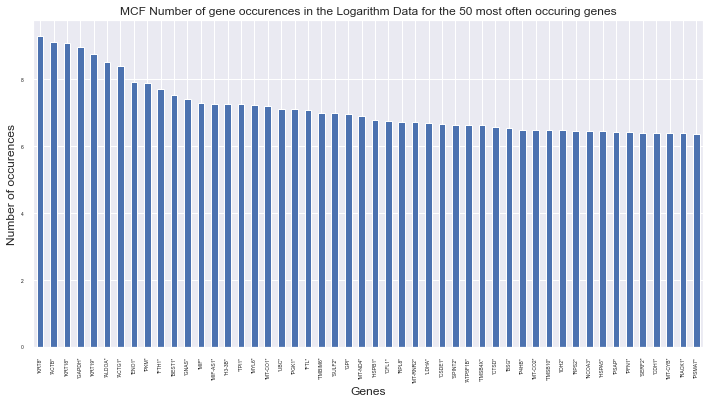

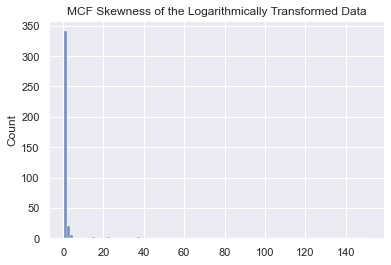

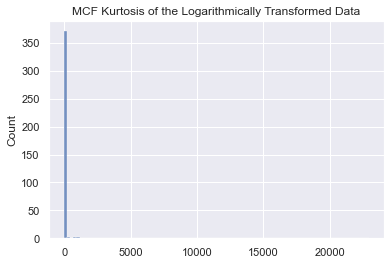

In [49]:
# Transform the Data using the Logarithm

hcc_unfiltered_log = np.log(hcc_unfiltered+1)
mcf_unfiltered_log = np.log(mcf_unfiltered+1)

# Analyse the Logarithm Data

def analyse_log(cell_line, var):

    cell_line.head()
    cell_line.describe()

    cnames = list(cell_line.columns)


    # Plot Violin Plots for the first 50 genes if the Logarithm Data

    unfiltered_log_fifty = cell_line.iloc[:, :50]
    np.shape(unfiltered_log_fifty)
    plt.figure(figsize=(16,4))
    plot=sns.violinplot(data=unfiltered_log_fifty,palette="Set3",cut=0)
    plt.setp(plot.get_xticklabels(), rotation=90)
    plt.title(var+" Violin Plot for the first 50 genes")
    plt.show()

    # Plot the number of gene occurences in the Logarithm Data for the 50 most often occuring genes

    n = cell_line.shape[1]
    largest = cell_line.sum(axis='columns').nlargest(50)/n
    plt.figure(figsize=(12,6))
    ax = largest.plot.bar(stacked = True, fontsize = 5)
    plt.xlabel('Genes')
    plt.ylabel('Number of occurences')
    plt.title(var+' Number of gene occurences in the Logarithm Data for the 50 most often occuring genes')
    plt.show()

    # Plot the Skewness of the Logarithmically Transformed Data

    colN = np.shape(cell_line)[1]
    unfiltered_log_skewness = []
    for i in range(colN):
        v_df = cell_line[cnames[i]]
        unfiltered_log_skewness.append(skew(v_df))


    sns.histplot(unfiltered_log_skewness,bins=100).set(title=var+' Skewness of the Logarithmically Transformed Data')
    plt.show()

    # Plot the Kurtosis of the Logarithmically Transformed Data

    colN = np.shape(cell_line)[1]
    unfiltered_log_kurtosis = []
    for i in range(colN):
        v_df = cell_line[cnames[i]]
        unfiltered_log_kurtosis.append(kurtosis(v_df))

    sns.histplot(unfiltered_log_kurtosis,bins=100).set(title=var+' Kurtosis of the Logarithmically Transformed Data')
    plt.show()



analyse_log(hcc_unfiltered_log, "HCC")
analyse_log(mcf_unfiltered_log, "MCF")

We can see the gene occurrences have less outliers after transforming the data. Overall we have achieved a more homogeneous dataset.
The transformation also effectively reduced the asymmetry in our distribution, rendering it more symmetric and normally distributed. The reduction in skewness and kurtosis resulted in a distribution that is more amenable to further statistical analyses that assume normality, enhancing the reliability of our results.
Since a value of zero indicates a perfectly symmetrical distribution for Skewness, we can see from this graph that the data, except for a few outliers, is now normally distributed. Therefore, we will work with the transformed dataset from here onwards.

The logarithmic transformation of our data also had a biological interpretation. It allowed us to transition from analyzing absolute changes, which can be greatly influenced by high-abundance genes, to analyzing relative changes, which are more biologically meaningful. 

Every single cell was sequenced independently, so normalizing the data between cells might be needed. First, let us plot the gene expression distributions for each cell and compare them.

In [50]:
# Update the original datasets
def update_datasets(cell_line, cell_line_log ,var):
    cell_line = cell_line_log

update_datasets(hcc_unfiltered, hcc_unfiltered_log, "HCC")
update_datasets(mcf_unfiltered, hcc_unfiltered_log, "MCF")


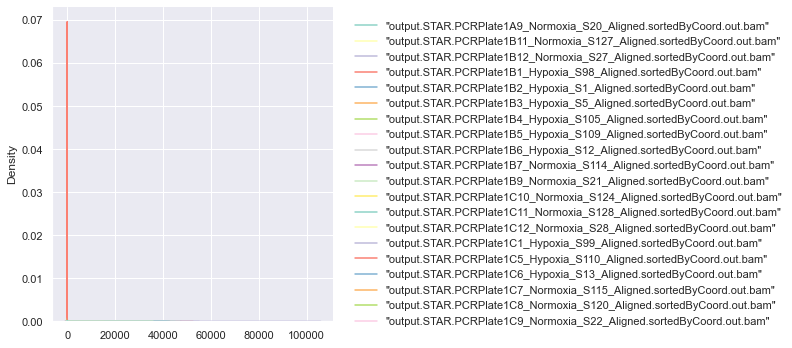

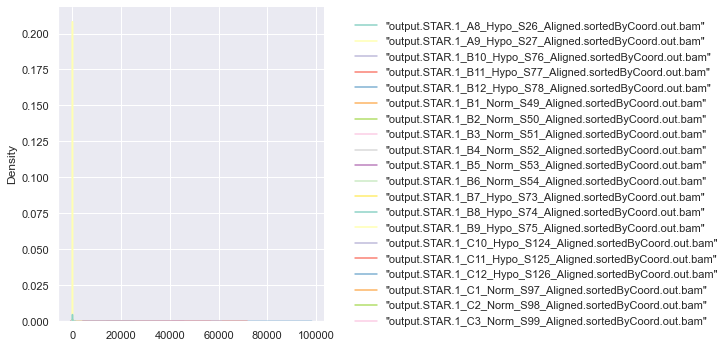

In [51]:
# Plot gene expression distribution for each cell

def gene_expression_distribution(cell_line, var):
    cell_line_small = cell_line.iloc[:, 10:30]  #just selecting part of the samples so run time not too long
    sns.displot(data=cell_line_small,palette="Set3",kind="kde", bw_adjust=2)

gene_expression_distribution(hcc_unfiltered, "HCC")
gene_expression_distribution(mcf_unfiltered, "MCF")

These graphs are clearly not normal. So let us normalize them using the z-score.

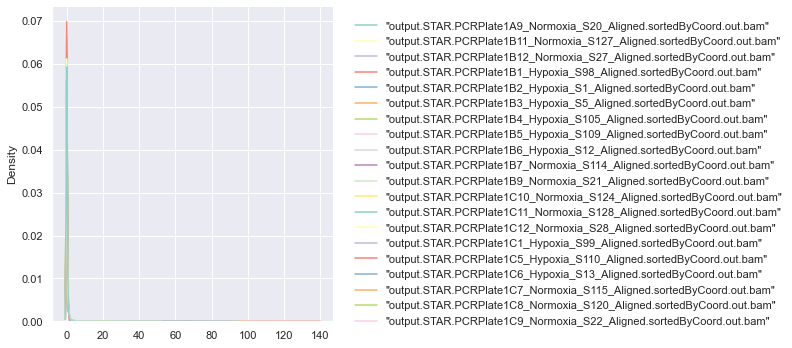

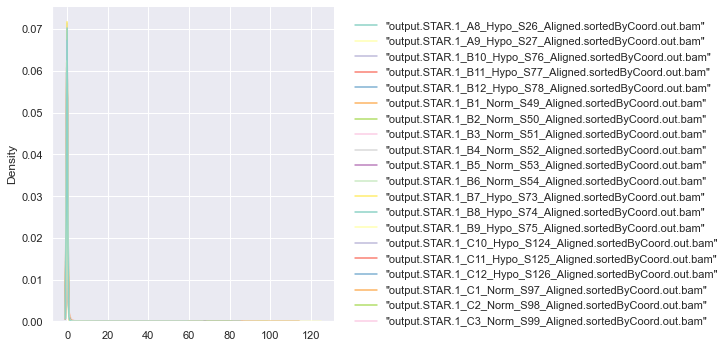

In [52]:
# Normalise the Gene Distribution of the cell lines

def normalise_gene_distribution(cell_line, var):
    cell_line_small = cell_line.iloc[:, 10:30]  #just selecting part of the samples so run time not too long
    cell_line_norm_small = cell_line_small.apply(stats.zscore)
    cell_line_norm = cell_line.apply(stats.zscore)
    sns.displot(data=cell_line_norm_small,palette="Set3",kind="kde", bw_adjust=2)

    return cell_line_norm

hcc_unfiltered_normalised = normalise_gene_distribution(hcc_unfiltered, "HCC")
mcf_unfiltered_normalised = normalise_gene_distribution(mcf_unfiltered, "MCF")

hcc_unfiltered = hcc_unfiltered_normalised
mcf_unfiltered = mcf_unfiltered_normalised



Post-normalization, our data showed a more consistent distribution of gene expression across all cells, with a significant reduction in technical noise. From here on out we will work with this updated dataset.

### 3.6. Remove Duplicates 

We will now move on to identifying duplicates. These can come in many forms. For example, a gene could be listed twice under different names but is equally expressed in all sample cells. So we have to look for genes which are equally expressed in all cells. This will give us an indication for whether they are duplicates or not. We will do this carefully, and note every intermediate step to eliminate any possible loss of information.

During this process we will first find and describe the duplicate genes, afterwards we will identify the correlation between those genes and lastly remove them from our data. 

In [53]:
def print_duplicate_genes(cell_line, var):
    # Print Names of Duplicate Genes

    duplicateRows_unfiltered = cell_line[cell_line.duplicated(keep=False)]
    print("Number of duplicate genes:", duplicateRows_unfiltered.shape)
    duplicateRows_unfiltered.describe()
    duplicateRows_unfiltered.count()

print_duplicate_genes(hcc_unfiltered_log, "HCC")
print_duplicate_genes(mcf_unfiltered_log, "MCF")

Number of duplicate genes: (89, 243)
Number of duplicate genes: (56, 383)


In [54]:
# Name of the duplicate genes

def duplicate_genes(cell_line, var):
    duplicateRows_unfiltered = cell_line[cell_line.duplicated(keep=False)]
    duplicateRows_unfiltered.index
    print("Names of duplicate genes:", duplicateRows_unfiltered.index)
    print("Number of duplicate genes:", duplicateRows_unfiltered.shape)

duplicate_genes(hcc_unfiltered_log, "HCC")
duplicate_genes(mcf_unfiltered_log, "MCF")

Names of duplicate genes: Index(['"MMP23A"', '"LINC01647"', '"LINC01361"', '"ITGA10"', '"RORC"',
       '"GPA33"', '"OR2M4"', '"LINC01247"', '"SNORD92"', '"LINC01106"',
       '"ZBTB45P2"', '"AOX3P"', '"CPS1"', '"RPS3AP53"', '"CCR4"', '"RNY1P12"',
       '"C4orf50"', '"C4orf45"', '"PCDHA2"', '"PCDHA8"', '"PCDHGA2"',
       '"PCDHGA3"', '"PCDHGB3"', '"PCDHGA7"', '"PCDHGA9"', '"PCDHGB7"',
       '"PCDHGA12"', '"PCDHGB9P"', '"PCDHGC4"', '"SMIM23"', '"PANDAR"',
       '"LAP3P2"', '"RBBP4P3"', '"RPL21P66"', '"VNN3"', '"TRPV6"', '"CNPY1"',
       '"ASS1P4"', '"SLC7A3"', '"MIR374B"', '"MIR374C"', '"NAB1P1"',
       '"RPL10AP3"', '"MIR548AA1"', '"MIR548D1"', '"SCARNA8"', '"MIR3074"',
       '"MIR24-1"', '"SUGT1P4-STRA6LP"', '"STRA6LP"', '"KCNA4"', '"FBLIM1P2"',
       '"APLNR"', '"CYCSP26"', '"OPCML"', '"B3GAT1-DT"', '"RPL21P88"',
       '"LINC02625"', '"RPL22P18"', '"PAX2"', '"SOX5"', '"COL2A1"',
       '"LINC02395"', '"LDHAL6CP"', '"CUX2"', '"LINC00621"', '"NUS1P2"',
       '"UBBP5"', '"OR5A

In [63]:
# Find the correlation between the duplicate genes

print("Correlation between duplicate genes for HCC:")
duplicateRows_unfiltered = hcc_unfiltered_log[hcc_unfiltered_log.duplicated(keep=False)]
duplicateRows_unfiltered_t = duplicateRows_unfiltered.T
c_dupl = duplicateRows_unfiltered_t.corr()
c_dupl[:5]

Correlation between duplicate genes for HCC:


,"""MMP23A""","""LINC01647""","""LINC01361""","""ITGA10""","""RORC""","""GPA33""","""OR2M4""","""LINC01247""","""SNORD92""","""LINC01106""",...,"""MSX2P1""","""MIR548D2""","""MIR548AA2""","""KCNJ16""","""CD300A""","""ENPP7""","""DTNA""","""ALPK2""","""OR7G2""","""PLVAP"""
"""MMP23A""",1.000000,-0.008299,-0.008299,-0.008299,-0.008299,-0.008299,-0.008299,-0.008299,-0.008299,-0.011157,...,-0.008299,-0.009833,-0.009833,-0.008299,-0.008299,-0.008299,-0.008299,-0.007355,-0.008299,-0.008299
"""LINC01647""",-0.008299,1.000000,0.495851,0.495851,-0.008299,0.495851,-0.008299,0.495851,-0.008299,0.306913,...,-0.008299,-0.009833,-0.009833,0.495851,0.495851,0.495851,0.495851,0.886297,0.495851,0.495851
"""LINC01361""",-0.008299,0.495851,1.000000,1.000000,0.495851,1.000000,0.495851,0.495851,-0.008299,-0.011157,...,-0.008299,-0.009833,-0.009833,0.495851,1.000000,0.495851,1.000000,0.206954,0.495851,1.000000
"""ITGA10""",-0.008299,0.495851,1.000000,1.000000,0.495851,1.000000,0.495851,0.495851,-0.008299,-0.011157,...,-0.008299,-0.009833,-0.009833,0.495851,1.000000,0.495851,1.000000,0.206954,0.495851,1.000000
"""RORC""",-0.008299,-0.008299,0.495851,0.495851,1.000000,0.495851,1.000000,-0.008299,-0.008299,-0.011157,...,-0.008299,-0.009833,-0.009833,-0.008299,0.495851,-0.008299,0.495851,-0.007355,-0.008299,0.495851


In [64]:
print("Correlation between duplicate genes for MCF:")
duplicateRows_unfiltered = mcf_unfiltered_log[mcf_unfiltered_log.duplicated(keep=False)]
duplicateRows_unfiltered_t = duplicateRows_unfiltered.T
c_dupl = duplicateRows_unfiltered_t.corr()
c_dupl[:5]

Correlation between duplicate genes for MCF:


,"""SHISAL2A""","""IL12RB2""","""S1PR1""","""CD84""","""GNLY""","""FAR2P3""","""KLF2P3""","""PABPC1P2""","""UGT1A8""","""UGT1A9""",...,"""BCL6B""","""CCL3L3""","""CCL3L1""","""OTOP3""","""RNA5SP450""","""PSG1""","""MIR3190""","""MIR3191""","""SEZ6L""","""ADAMTS5"""
"""SHISAL2A""",1.000000,0.595969,0.600789,0.374125,0.497375,-0.008333,-0.008333,0.497375,-0.013522,-0.013522,...,0.497375,-0.011697,-0.011697,0.251552,-0.005249,0.497375,-0.005249,-0.005249,0.233664,0.595969
"""IL12RB2""",0.595969,1.000000,0.719609,0.902085,0.595969,-0.008126,-0.008126,0.975214,-0.013187,-0.013187,...,0.595969,-0.011407,-0.011407,0.801883,-0.005119,0.595969,-0.005119,-0.005119,0.785477,0.713849
"""S1PR1""",0.600789,0.719609,1.000000,0.452186,0.600789,-0.008102,-0.008102,0.600789,-0.013148,-0.013148,...,0.600789,-0.011372,-0.011372,0.304354,-0.005104,0.600789,-0.005104,-0.005104,0.282777,0.719609
"""CD84""",0.374125,0.902085,0.452186,1.000000,0.374125,-0.008126,-0.008126,0.975214,-0.013187,-0.013187,...,0.374125,-0.011407,-0.011407,0.981215,-0.005119,0.374125,-0.005119,-0.005119,0.975655,0.448546
"""GNLY""",0.497375,0.595969,0.600789,0.374125,1.000000,-0.008333,-0.008333,0.497375,-0.013522,-0.013522,...,1.000000,0.113449,0.113449,0.251552,-0.005249,0.497375,-0.005249,-0.005249,0.233664,0.975214


In [65]:
print("Description of duplicate genes for HCC:")
duplicateRows_unfiltered = hcc_unfiltered_log[hcc_unfiltered_log.duplicated(keep=False)]
duplicateRows_unfiltered_t = duplicateRows_unfiltered.T
duplicateRows_unfiltered_t
c_dupl = duplicateRows_unfiltered_t.corr()
c_dupl.describe()

Description of duplicate genes for HCC:


,"""MMP23A""","""LINC01647""","""LINC01361""","""ITGA10""","""RORC""","""GPA33""","""OR2M4""","""LINC01247""","""SNORD92""","""LINC01106""",...,"""MSX2P1""","""MIR548D2""","""MIR548AA2""","""KCNJ16""","""CD300A""","""ENPP7""","""DTNA""","""ALPK2""","""OR7G2""","""PLVAP"""
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,...,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,0.019639,0.220699,0.316700,0.316700,0.144990,0.316700,0.144990,0.186391,0.008453,0.033528,...,0.025993,0.016420,0.016420,0.194891,0.316700,0.184520,0.316700,0.128597,0.192090,0.316700
std,0.151706,0.295125,0.411280,0.411280,0.259673,0.411280,0.259673,0.277949,0.151836,0.175467,...,0.153433,0.152158,0.152158,0.270819,0.411280,0.279322,0.411280,0.230491,0.272912,0.411280
min,-0.058396,-0.084966,-0.065478,-0.065478,-0.065478,-0.065478,-0.065478,-0.084966,-0.072081,-0.096907,...,-0.049706,-0.056509,-0.056509,-0.058396,-0.065478,-0.084966,-0.065478,-0.075305,-0.058396,-0.065478
25%,-0.008299,-0.009533,-0.010113,-0.010113,-0.009833,-0.010113,-0.009833,-0.010113,-0.010113,-0.011157,...,-0.008299,-0.009833,-0.009833,-0.009833,-0.010113,-0.011157,-0.010113,-0.008449,-0.008299,-0.010113
50%,-0.008299,-0.008299,-0.008299,-0.008299,-0.008299,-0.008299,-0.008299,-0.008299,-0.008299,-0.011157,...,-0.008299,-0.009833,-0.009833,-0.008299,-0.008299,-0.008299,-0.008299,-0.007355,-0.008299,-0.008299
75%,-0.008299,0.495851,0.495851,0.495851,0.372274,0.495851,0.372274,0.495851,-0.008299,-0.011157,...,-0.008299,-0.009588,-0.009588,0.495851,0.495851,0.495851,0.495851,0.206954,0.495851,0.495851
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [66]:
print("Description of duplicate genes for MCF:")
duplicateRows_unfiltered = mcf_unfiltered_log[mcf_unfiltered_log.duplicated(keep=False)]
duplicateRows_unfiltered_t = duplicateRows_unfiltered.T
duplicateRows_unfiltered_t
c_dupl = duplicateRows_unfiltered_t.corr()
c_dupl.describe()

Description of duplicate genes for MCF:


,"""SHISAL2A""","""IL12RB2""","""S1PR1""","""CD84""","""GNLY""","""FAR2P3""","""KLF2P3""","""PABPC1P2""","""UGT1A8""","""UGT1A9""",...,"""BCL6B""","""CCL3L3""","""CCL3L1""","""OTOP3""","""RNA5SP450""","""PSG1""","""MIR3190""","""MIR3191""","""SEZ6L""","""ADAMTS5"""
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,...,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,0.239628,0.344786,0.279412,0.292079,0.264162,0.027982,0.027982,0.326526,0.025825,0.025825,...,0.264162,0.044956,0.044956,0.250247,0.028404,0.237172,0.037839,0.037839,0.243651,0.297730
std,0.293562,0.396969,0.330240,0.378342,0.330746,0.189218,0.189218,0.392197,0.190332,0.190332,...,0.330746,0.190542,0.190542,0.360320,0.188762,0.295558,0.189150,0.189150,0.357489,0.358626
min,-0.020348,-0.030417,-0.030325,-0.030417,-0.031190,-0.032300,-0.032300,-0.031190,-0.030130,-0.030130,...,-0.031190,-0.030130,-0.030130,-0.028514,-0.031190,-0.031190,-0.013522,-0.013522,-0.028163,-0.030417
25%,-0.005335,-0.005863,-0.005187,-0.005863,-0.005335,-0.008333,-0.008333,-0.006012,-0.013522,-0.013522,...,-0.005335,-0.011697,-0.011697,-0.005496,-0.006012,-0.006012,-0.005249,-0.005249,-0.005428,-0.005203
50%,0.016223,-0.004992,0.043491,-0.004992,0.054165,-0.008333,-0.008333,-0.005119,-0.013522,-0.013522,...,0.054165,-0.011407,-0.011407,-0.004680,-0.005249,-0.005119,-0.005249,-0.005249,-0.004622,0.039013
75%,0.497375,0.713849,0.600789,0.448546,0.497375,-0.008126,-0.008126,0.595969,-0.013187,-0.013187,...,0.497375,0.003298,0.003298,0.301890,-0.005119,0.497375,-0.005119,-0.005119,0.280484,0.595969
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
def remove_duplicate_genes(cell_line, var):
    
    duplicateRows_unfiltered = cell_line[cell_line.duplicated(keep=False)]
    duplicateRows_unfiltered.index
    # Remove Duplicate Genes

    cell_line = cell_line[~cell_line.index.duplicated(keep='first')]
    print("Number of duplicate genes:", duplicateRows_unfiltered.shape)
    print("Number of genes after removing duplicates:", cell_line.shape)
    

remove_duplicate_genes(hcc_unfiltered_log, "HCC")
remove_duplicate_genes(mcf_unfiltered_log, "MCF")

Number of duplicate genes: (89, 243)
Number of genes after removing duplicates: (23396, 243)
Number of duplicate genes: (56, 383)
Number of genes after removing duplicates: (22934, 383)


After identifying these, lets drop the duplicates.

In [68]:
# Dropping the Duplicate Genes

hcc_unfiltered_log = hcc_unfiltered_log[~hcc_unfiltered_log.index.duplicated(keep='first')]
mcf_unfiltered_log = mcf_unfiltered_log[~mcf_unfiltered_log.index.duplicated(keep='first')]

# Updating the Data

hcc_unfiltered = hcc_unfiltered_log
mcf_unfiltered = mcf_unfiltered_log

### 3.7. Analyzing the Correlation in the data

Now we will move on to understand the correlation in the data. First and foremost, it enables the detection of similarities or patterns across different cell samples. Correlation analysis can highlight shared gene expression patterns indicative of common biological processes or responses. A low correlation between samples, however, might suggest heterogeneity in the biological state or response which is useful when trying to build the classifier.

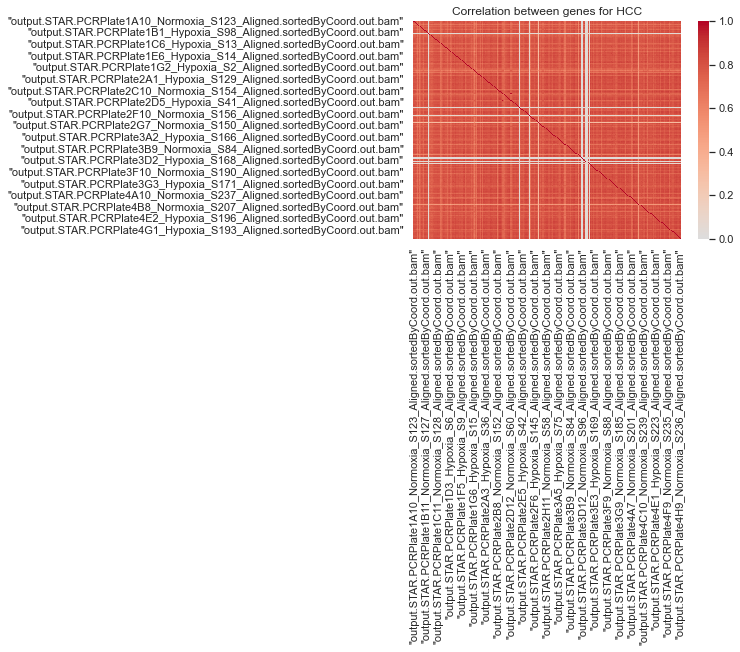

Number of genes with a correlation of 1: 243
Number of gene included: (243, 243)
Average correlation: 0.5015433380259116
Minimum correlation: 0.0030866760518231443


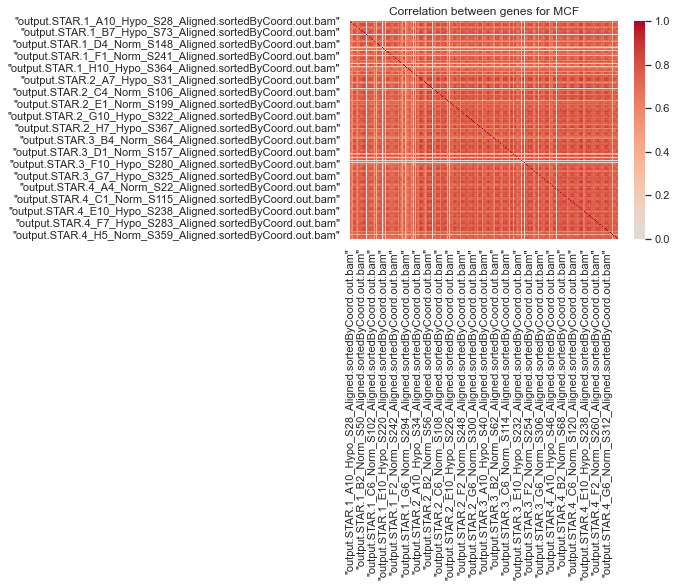

Number of genes with a correlation of 1: 383
Number of gene included: (383, 383)
Average correlation: 0.4970095706955189
Minimum correlation: -0.005980858608962109


In [69]:
# Check correlation between genes

def correlation(cell_line, var):
    c = cell_line.corr()
    midpoint = (c.values.max() - c.values.min()) / 2 + c.values.min()
    sns.heatmap(c, cmap='coolwarm', vmin=0, vmax=1, center=0).set_title("Correlation between genes for "+var)
    plt.show()
    print("Number of genes with a correlation of 1:", sum(c[c==1].count()))
    print("Number of gene included:",np.shape(c))
    print("Average correlation:", midpoint)
    print("Minimum correlation:", c.values.min())

correlation(hcc_unfiltered, "HCC")
correlation(mcf_unfiltered, "MCF")

This is a good result. There are precisely 243 cells with a correlation of 1 in the HCC dataset and 383 in the MCF dataset, meaning that except for the comparison with itself, no gene expression is equivalent to another. So there are no duplicates among the cells. We can see this in the diagonal line going through the heatmap. Furthermore, we can identify the light lines in the graph, which indicate gene expressions with little to no correlation to the other ones.

Now we try and plot the correlation between the distribution of the gene expression in some random cells in order to understand how the cells interact with each other.

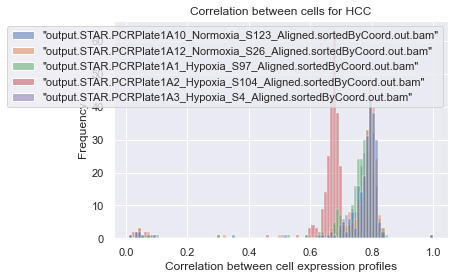

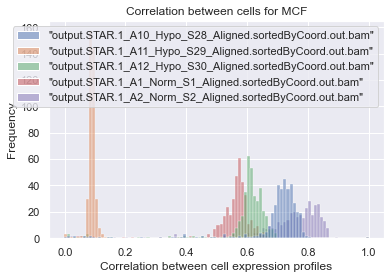

In [71]:
def correlation_between_cells(cell_line, var):
    c = cell_line.corr()
    np.shape(c)
    type(c)
    c.head(3)
    c_small=c.iloc[:,:5]
    sns.histplot(c_small,bins=100).set_title("Correlation between cells for "+var)
    plt.ylabel('Frequency')
    plt.xlabel('Correlation between cell expression profiles')
    plt.show()

correlation_between_cells(hcc_unfiltered, "HCC")
correlation_between_cells(mcf_unfiltered, "MCF")

The correlation between the cells is much higher for the HCC dataset than for the MCF dataset. However, it is likely, that the orange cell with a low correlation at the left of the MCF is an outlier. 

This concludes our Exploratory Data Analysis. To summarize, first we have a gained some general insights insights into the data by visualising some individual genes and cells as well as the general distribution of occurences. Then we looked for missing values, and could not find any. Afterwards, we unsuccessfully attempted to identify outliers, using IQR and the Z-Score method, which we could remove in order to achieved a more homogeneous dataset. However, this was not possible since the outliers carried valuable information. Our next step was to understand the distribution of the data and subsequently normalise it using logarithms. 
Lastly we detected and removed duplicates and analysed some correlation between cells.

First, we have gained a general understanding of the data we are working with and will now move on to actually training a classifier which can identify whether a cell is sampled from Hypoxia or Normoxia gene expressions. 

# 4. The Model

The model training is the most important of our report and involves us building a binary classifier to determine whether a cell is sampled from a Hypoxic or Normoxic environment. The previous EDA aids us in this process, since it makes easier to understand and interpret the results we have and it gives us an indicator as to which models will work well with the provided data. 

## 4.1 Unsupervised Learning

In the unsupervised learning section of our machine learning project, we attempt to group the cells into two groups based on their gene expressions. We will verify that this grouping indeed represents the condition (Hypoxia or Normoxia) of the cell. This task is useful for identifying potential patterns within the data. Our approach begins with Principal Component Analysis (PCA), a dimensionality reduction technique that uncovers the most informative features. By reducing the dimensionality, we aim to retain critical information while simplifying the dataset. Subsequently, we employ the classical K-means algorithm to cluster the cells based on their gene expression patterns. This combination of PCA and K-means enables us to discover underlying structures and gain valuable insights into the cellular classification process.

#### 4.1.1. Principal Component Analysis (PCA)

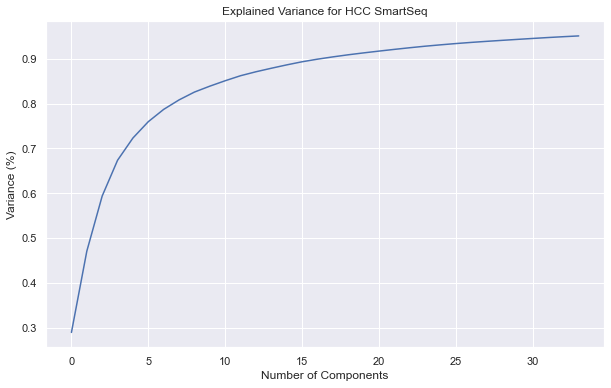

Number of components explaining 95% of the variance for HCC SmartSeq: 34



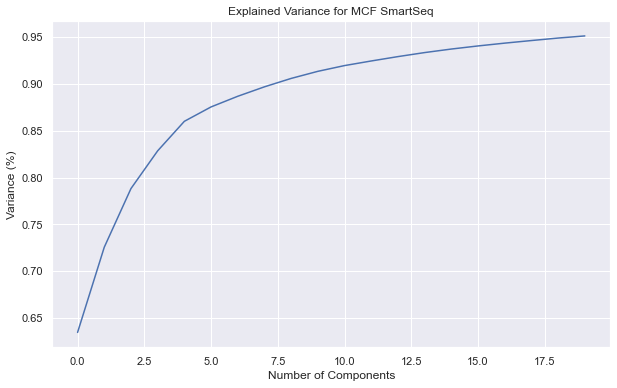

Number of components explaining 95% of the variance for MCF SmartSeq: 20



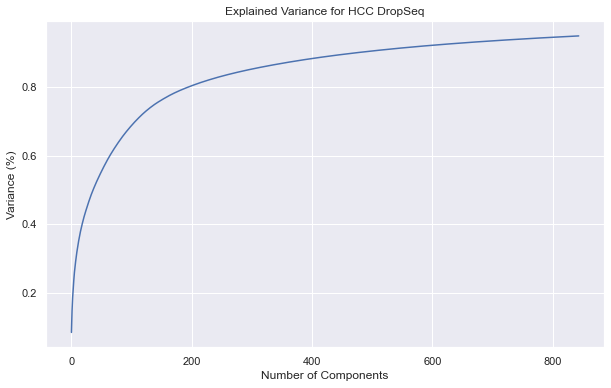

Number of components explaining 95% of the variance for HCC DropSeq: 844



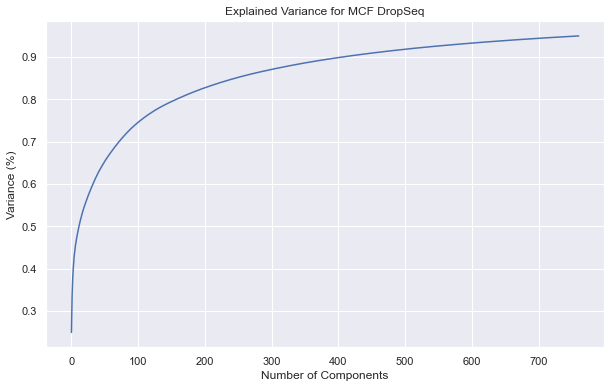

Number of components explaining 95% of the variance for MCF DropSeq: 761



In [72]:
# Run PCA 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans


def pca(cell_line, var):

    # Input the rows as features and the columns as samples
    X = cell_line.T 
    
    # Run PCA
    pca = PCA(n_components=0.95)
    pca.fit(X)
    principal_components = pca.fit_transform(X)

    # Plot the Explained Variance Ratio
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') #for each component
    plt.title('Explained Variance for '+var)
    plt.show()

    # Find how many components explain 95% of the variance
    pca = PCA(.95)
    pca.fit(X)
    pca.n_components_
    print("Number of components explaining 95% of the variance for "+var+":", pca.n_components_)
    print()

    return pd.DataFrame(data = principal_components)



hcc_SmartSeq_principal_components = pca(hcc_filtered_normalized_train, "HCC SmartSeq")
mcf_SmartSeq_principal_components = pca(mcf_filtered_normalized_train, "MCF SmartSeq")
hcc_DropSeq_principal_components = pca(hcc_drop_filtered_normalised_train, "HCC DropSeq")
mcf_DropSeq_principal_components = pca(mcf_drop_filtered_normalised_train, "MCF DropSeq")

When performing the PCA algorithm we choose the number of components so that we retain 95% of the variance. Intuitivly the less components we keep the more variance each carries, this relationship is depicted in the graphs above. Interestingly the Drop Seq dataset requires a much larger amount of features than the Smart Seq dataset in order to reach 95% explained variance. There can be many reasons for this including the smaller size of the Drop Seq Dataset.

#### 4.1.2 K-Means Clustering

We now move on to clustering the data using the K-Means method. We chose this method since its scalable, meaning it can handle large datasets, it is fast, even for expansive datasets and because it is fairly easy to interpret.

In [76]:
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

def kmeans_clustering(X, y, var):
    
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    km = KMeans(n_clusters=2)
    km.fit(X_std)
    y_pred = km.predict(X_std)
    
    # Find number of points in each cluster
    unique, counts = np.unique(y_pred, return_counts=True)
    print("Number of points in each cluster for "+var+":", dict(zip(unique, counts)))

    # print(len(y))
    # print(len(y_pred))
    # Print accuracy score
    print("Accuracy score for "+var+":", max(accuracy_score(y, y_pred), 1-accuracy_score(y, y_pred)))


# print(hcc_filtered_normalized_train.columns)
hcc_filtered_normalized_train_label = hcc_metadata.loc[[i[1:-1] for i in hcc_filtered_normalized_train.columns], "Condition"]
hcc_filtered_normalized_train_label = [1 if i == "Hypo" else 0 for i in hcc_filtered_normalized_train_label]
mcf_filtered_normalized_train_label = mcf_metadata.loc[[i[1:-1] for i in mcf_filtered_normalized_train.columns], "Condition"]
mcf_filtered_normalized_train_label = [1 if i == "Hypo" else 0 for i in mcf_filtered_normalized_train_label]
hcc_drop_filtered_normalised_train_label = hcc_drop_filtered_normalised_train.columns.str.contains('Hypo').astype(int)
mcf_drop_filtered_normalised_train_label = mcf_drop_filtered_normalised_train.columns.str.contains('Hypo').astype(int)

# print(len(hcc_filtered_normalized_train_label))

kmeans_clustering(hcc_filtered_normalized_train.T, hcc_filtered_normalized_train_label, "HCC SmartSeq")
kmeans_clustering(mcf_filtered_normalized_train.T, mcf_filtered_normalized_train_label, "MCF SmartSeq")
kmeans_clustering(hcc_drop_filtered_normalised_train.T, hcc_drop_filtered_normalised_train_label, "HCC DropSeq")
kmeans_clustering(mcf_drop_filtered_normalised_train.T, mcf_drop_filtered_normalised_train_label, "MCF DropSeq")

kmeans_clustering(hcc_SmartSeq_principal_components, hcc_filtered_normalized_train_label, "HCC SmartSeq PCA")
kmeans_clustering(mcf_SmartSeq_principal_components, mcf_filtered_normalized_train_label, "MCF SmartSeq PCA")
kmeans_clustering(hcc_DropSeq_principal_components, hcc_drop_filtered_normalised_train_label, "HCC DropSeq PCA")
kmeans_clustering(mcf_DropSeq_principal_components, mcf_drop_filtered_normalised_train_label, "MCF DropSeq PCA")

Number of points in each cluster for HCC SmartSeq: {0: 15, 1: 167}
Accuracy score for HCC SmartSeq: 0.5054945054945055
Number of points in each cluster for MCF SmartSeq: {0: 125, 1: 125}
Accuracy score for MCF SmartSeq: 0.988
Number of points in each cluster for HCC DropSeq: {0: 14671, 1: 11}
Accuracy score for HCC DropSeq: 0.6060482223130363
Number of points in each cluster for MCF DropSeq: {0: 6489, 1: 15137}
Accuracy score for MCF DropSeq: 0.856561546286877
Number of points in each cluster for HCC SmartSeq PCA: {0: 1, 1: 181}
Accuracy score for HCC SmartSeq PCA: 0.5274725274725275
Number of points in each cluster for MCF SmartSeq PCA: {0: 115, 1: 135}
Accuracy score for MCF SmartSeq PCA: 0.964
Number of points in each cluster for HCC DropSeq PCA: {0: 304, 1: 14378}
Accuracy score for HCC DropSeq PCA: 0.601757253780139
Number of points in each cluster for MCF DropSeq PCA: {0: 437, 1: 21189}
Accuracy score for MCF DropSeq PCA: 0.5755109590307963


After performing the Kmeans algorithm we measured their accuracy using their labels.  We see that the accuracy results for the datasets with reduced dimentionality (PCA outputs) are significantly lower than the ones of the original datasets. One reason why we might achieve better results when performing K-means on the original dataset, is that PCA can sometimes lead to information loss. While PCA aims to retain the most informative features, the dimensionality reduction process may discard certain subtle but relevant patterns or variations present in the original data. By directly applying K-means on the original dataset, we retain the full complexity and richness of the gene expression information, allowing the algorithm to capture a more detailed representation of the underlying clusters. This approach can potentially yield better results and provide a more comprehensive understanding of the cellular classification task.

## 4.2. Supervised Learning

We will begin by attempting to classify the cells using XGBoost. The general idea of XG Boost is, to combine multiple weak decision trees to create a robust predictive model. XGBoost uses a gradient boosting framework, which iteratively trains decision trees on the residuals of the previous tree to improve model accuracy. We chose this model over conventional supervised learningn algorithms, such as Support Vector Machine (SVM) and Logistic Regression, for a variety of reasons. Firstly, it does not assume linear decision boundaries by leveraging decision trees. Secondly, since we were not able to detect any meaningful outliers in our EDA, the built in outlier detection of the XG Boost algorithm came in handy. Thirdly, XG Boost performs well in balancing noisy datasets, which is useful for genetic processing and in particular in our case, since we have sparse data with some large values in it. And lastly, it is efficient and scalable, which is clearly also beneficial for our purposes. 

This section is split into 5 secions
1. Creating functions to format the data for the XGBoost algorithm
2. Creating and training the models (takes ~60min to run)
3. Saving the models in a Pickle file
4. Loading the models from the Pickle file
5. Evaluating the model's accuracy
6. Plotting feature importance

A Note on the Creation and Training of the Models:

For each of the four datasets, we create an individual model that is only trained on that specific data. When creating each model, we perform a hyperparameter search to determine the optimal hyperparameters for our XGBoost Classifer. Due to our limited computing resources, we only perform the search on a parameter space of three hyperparameters with three values each. To determine the quality of each model (both in the hyperparameter search and the final evaluation), we use k-fold cross-validation (with k=5 and k=10, respectively). We know that the best hyperparameters we determined are extreme parameter space points; given more computing power, we could have expanded the space to validate if the model improves with different parameters.


In [78]:
# 1. Creating functions to foramt the data for the XGBoost algorithm

def format_Data_SmartSeq(training_data, metadata):
    # Format the data and its labels
    X = training_data.transpose()
    y = metadata.loc[[i[1:-1] for i in X.index.to_numpy()], "Condition"]
    y = [1 if i == "Hypo" else 0 for i in y]

    return X, y

def format_data_DropSeq(data):
    # Format the data and its labels
    X = data.transpose()
    y = np.array(data.columns.str.contains('Hypo'), dtype=int).transpose()

    return X, y

In [ ]:
# 2. Creating and training the models (takes ~60min to run)


def ceate_and_train_model(train, labels):

    # Create the model
    model = xgb.XGBClassifier(objective="binary:logistic", random_state=0, tree_method='gpu_hist')
    
    param_grid = {
        'learning_rate': [0.1, 0.2, 0.3],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200, 300]
    }
    
    gridSearch = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, refit=True, verbose=3)
    gridSearch.fit(train, labels)
    
    model = gridSearch.best_estimator_

    return model, gridSearch

def xgboost_model_SmartSeq(training_data, metadata):
    # Format the data and its labels
    X , y = format_Data_SmartSeq(training_data, metadata)
    return ceate_and_train_model(X, y)

def xgboost_model_DropSeq(data):
    # Format the data and its labels
    X , y = format_data_DropSeq(data)
    return ceate_and_train_model(X, y)

hcc_xgb_model_SmartSeq, hhc_xgb_gridSearch_SmartSeq = xgboost_model_SmartSeq(hcc_filtered_normalized_train, hcc_metadata)
mcf_xgb_model_SmartSeq, mcf_xgb_gridSearch_SmartSeq = xgboost_model_SmartSeq(mcf_filtered_normalized_train, mcf_metadata)
hcc_xgb_model_DropSeq, hhc_xgb_gridSearch_DropSeq = xgboost_model_DropSeq(hcc_drop_filtered_normalised_train)
mcf_xgb_model_DropSeq, mcf_xgb_gridSearch_DropSeq = xgboost_model_DropSeq(mcf_drop_filtered_normalised_train)

models_and_gridSearches = {
    "hcc_xgb_model_SmartSeq" : hcc_xgb_model_SmartSeq, 
    "hhc_xgb_gridSearch_SmartSeq": hhc_xgb_gridSearch_SmartSeq, 
    "mcf_xgb_model_SmartSeq": mcf_xgb_model_SmartSeq, 
    "mcf_xgb_gridSearch_SmartSeq": mcf_xgb_gridSearch_SmartSeq, 
    "hcc_xgb_model_DropSeq": hcc_xgb_model_DropSeq, 
    "hhc_xgb_gridSearch_DropSeq": hhc_xgb_gridSearch_DropSeq, 
    "mcf_xgb_model_DropSeq": mcf_xgb_model_DropSeq, 
    "mcf_xgb_gridSearch_DropSeq": mcf_xgb_gridSearch_DropSeq}

In [ ]:
# 3 Saving the models in a Pickle file

with open("data.pickle", "wb") as file:
    pickle.dump(models_and_gridSearches, file)

In [80]:
# 4. Loading the models from the Pickle file

models_and_gridSearches = pickle.load(open("data.pickle", "rb"))

model_hcc_smartSeq = models_and_gridSearches["hcc_xgb_model_SmartSeq"]
model_mcf_smartSeq = models_and_gridSearches["mcf_xgb_model_SmartSeq"]
model_hcc_dropSeq = models_and_gridSearches["hcc_xgb_model_DropSeq"]
model_mcf_dropSeq = models_and_gridSearches["mcf_xgb_model_DropSeq"]
hhc_xgb_gridSearch_SmartSeq = models_and_gridSearches["hhc_xgb_gridSearch_SmartSeq"]
mcf_xgb_gridSearch_SmartSeq = models_and_gridSearches["mcf_xgb_gridSearch_SmartSeq"]
hhc_xgb_gridSearch_DropSeq = models_and_gridSearches["hhc_xgb_gridSearch_DropSeq"]
mcf_xgb_gridSearch_DropSeq = models_and_gridSearches["mcf_xgb_gridSearch_DropSeq"]

In [81]:
# 5. Evaluating the models accuracy

train_hcc_smartSeq, labels_hcc_smartSeq = format_Data_SmartSeq(hcc_filtered_normalized_train, hcc_metadata)
train_mcf_smartSeq, labels_mcf_smartSeq = format_Data_SmartSeq(mcf_filtered_normalized_train, mcf_metadata)
train_hcc_dropSeq, labels_hcc_dropSeq = format_data_DropSeq(hcc_drop_filtered_normalised_train)
train_mcf_dropSeq, labels_mcf_dropSeq = format_data_DropSeq(mcf_drop_filtered_normalised_train)

hcc_smartSeq_scores = cross_val_score(model_hcc_smartSeq, train_hcc_smartSeq, labels_hcc_smartSeq, cv=10)
mcf_smartSeq_scores = cross_val_score(model_mcf_smartSeq, train_mcf_smartSeq, labels_mcf_smartSeq, cv=10)
hcc_dropSeq_scores = cross_val_score(model_hcc_dropSeq, train_hcc_dropSeq, labels_hcc_dropSeq, cv=10)
mcf_dropSeq_scores = cross_val_score(model_mcf_dropSeq, train_mcf_dropSeq, labels_mcf_dropSeq, cv=10)

print("HCC SmartSeq model accuracy: %0.5f %% (+/- %0.5f %%)" % (hcc_smartSeq_scores .mean()*100, hcc_smartSeq_scores.std() * 2 * 100))
print("MCF SmartSeq model accuracy: %0.5f %% (+/- %0.5f %%)" % (mcf_smartSeq_scores .mean()*100, mcf_smartSeq_scores.std() * 2 * 100))
print("HCC DropSeq model accuracy: %0.5f %% (+/- %0.5f %%)" % (hcc_dropSeq_scores .mean()*100, hcc_dropSeq_scores.std() * 2 * 100))
print("MCF DropSeq model accuracy: %0.5f %% (+/- %0.5f %%)" % (mcf_dropSeq_scores .mean()*100, mcf_dropSeq_scores.std() * 2 * 100))

HCC SmartSeq model accuracy: 97.77778 % (+/- 7.37028 %)
MCF SmartSeq model accuracy: 98.40000 % (+/- 5.30660 %)
HCC DropSeq model accuracy: 95.97458 % (+/- 1.64847 %)
MCF DropSeq model accuracy: 98.41859 % (+/- 0.47640 %)


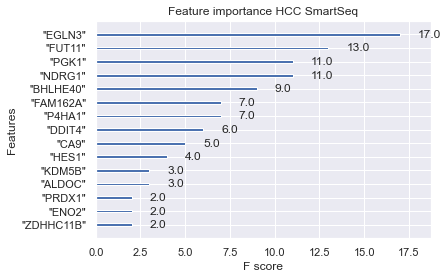

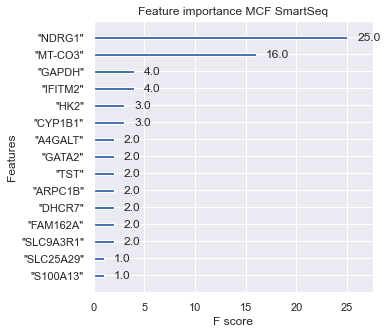

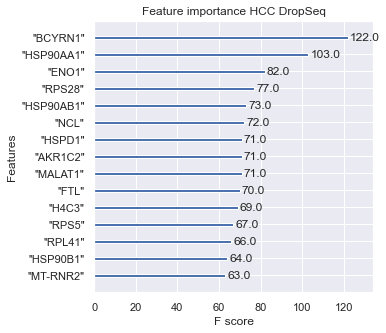

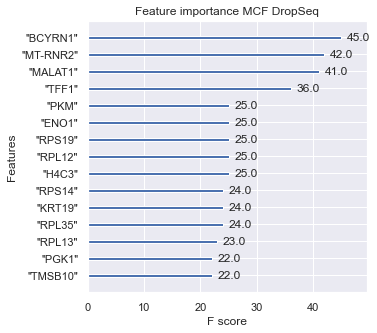

In [82]:
# 6. Plotting feature importance

models = [model_hcc_smartSeq, model_mcf_smartSeq, model_hcc_dropSeq, model_mcf_dropSeq]
names = ["HCC SmartSeq", "MCF SmartSeq", "HCC DropSeq", "MCF DropSeq"]


for model, name in zip(models, names):
        xgb.plot_importance(model, max_num_features=15)
        plt.rcParams['figure.figsize'] = [5, 5]
        plt.title("Feature importance " + name)
        plt.show()

The overall result of the models is very good, scoring an accuracy of above 90% for all the datasets. It best models the MCF DropSeq dataset with an accuracy of 98.41%  and a variance of +/- 0.5%. For each dataset the model has important genes which its performance relies upon, as illustrated by our graphs. This might have direct applications. Although the difference in relavance in the 15 most relavant genes varies greatly in some datasets, you can clearly see the most relavent genes in all datasets (see graphs).

## 4.3 Model conclusions and final predictions

Clearly - and not suprisingly - our supervised algorithm drastically outperforms our unsupervised algorithm. Therefore we are going to use our supervised XGBoost model for the final classification of cells.

We will now make our predictions and then export them into a csv file for further evaluation:

In [83]:
# 1. Load data for prediction

hcc_SmartS_Filtered_Normalised_3000_Data_test_anonimised = pd.read_csv(path +"SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt", sep=" ", index_col=0)
mcf_SmartS_Filtered_Normalised_3000_Data_test_anonimised = pd.read_csv(path +"SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt", sep=" ", index_col=0)
hcc_DropS_Filtered_Normalised_3000_Data_test_anonimised = pd.read_csv(path +"Dropseq/HCC1806_Filtered_Normalised_3000_Data_test_anonim.txt", sep=" ", index_col=0)
mcf_DropS_Filtered_Normalised_3000_Data_test_anonimised = pd.read_csv(path +"Dropseq/MCF7_Filtered_Normalised_3000_Data_test_anonim.txt", sep=" ", index_col=0)

hcc_SmartS_Filtered_Normalised_3000_Data_test_anonimised = hcc_SmartS_Filtered_Normalised_3000_Data_test_anonimised.rename(lambda x: '"' + x +'"')
mcf_SmartS_Filtered_Normalised_3000_Data_test_anonimised = mcf_SmartS_Filtered_Normalised_3000_Data_test_anonimised.rename(lambda x: '"' + x +'"')
hcc_DropS_Filtered_Normalised_3000_Data_test_anonimised = hcc_DropS_Filtered_Normalised_3000_Data_test_anonimised.rename(lambda x: '"' + x +'"')
mcf_DropS_Filtered_Normalised_3000_Data_test_anonimised = mcf_DropS_Filtered_Normalised_3000_Data_test_anonimised.rename(lambda x: '"' + x +'"')

# 2. Make predictions

hcc_SmartS_Filtered_Normalised_3000_Data_test_anonimised_predict = model_hcc_smartSeq.predict(hcc_SmartS_Filtered_Normalised_3000_Data_test_anonimised.transpose())
mcf_SmartS_Filtered_Normalised_3000_Data_test_anonimised_predict = model_mcf_smartSeq.predict(mcf_SmartS_Filtered_Normalised_3000_Data_test_anonimised.transpose())
hcc_DropS_Filtered_Normalised_3000_Data_test_anonimised_predict = model_hcc_dropSeq.predict(hcc_DropS_Filtered_Normalised_3000_Data_test_anonimised.transpose())
mcf_DropS_Filtered_Normalised_3000_Data_test_anonimised_predict = model_mcf_dropSeq.predict(mcf_DropS_Filtered_Normalised_3000_Data_test_anonimised.transpose())

# 3. format data for data export

hcc_smartSeq_prediction_tabel = pd.DataFrame(
    ["Hypoxia" if i == 1 else "Normoxia" for i in hcc_SmartS_Filtered_Normalised_3000_Data_test_anonimised_predict], 
    index=hcc_SmartS_Filtered_Normalised_3000_Data_test_anonimised.columns, 
    columns=["Prediction"])
mcf_smartSeq_prediction_tabel = pd.DataFrame(
    ["Hypoxia" if i == 1 else "Normoxia" for i in mcf_SmartS_Filtered_Normalised_3000_Data_test_anonimised_predict],
    index=mcf_SmartS_Filtered_Normalised_3000_Data_test_anonimised.columns,
    columns=["Prediction"])
hcc_dropSeq_prediction_tabel = pd.DataFrame(    
    ["Hypoxia" if i == 1 else "Normoxia" for i in hcc_DropS_Filtered_Normalised_3000_Data_test_anonimised_predict],
    index=hcc_DropS_Filtered_Normalised_3000_Data_test_anonimised.columns,
    columns=["Prediction"])
mcf_dropSeq_prediction_tabel = pd.DataFrame(
    ["Hypoxia" if i == 1 else "Normoxia" for i in mcf_DropS_Filtered_Normalised_3000_Data_test_anonimised_predict],
    index=mcf_DropS_Filtered_Normalised_3000_Data_test_anonimised.columns,
    columns=["Prediction"])

# 4. Export data

hcc_smartSeq_prediction_tabel.to_csv(path + "/HCC1806_SmartS_Filtered_Normalised_3000_Data_test_anonim_prediction.txt", sep="\t")
mcf_smartSeq_prediction_tabel.to_csv(path + "/MCF7_SmartS_Filtered_Normalised_3000_Data_test_anonim_prediction.txt", sep="\t")
hcc_dropSeq_prediction_tabel.to_csv(path + "/HCC1806_DropS_Filtered_Normalised_3000_Data_test_anonim_prediction.txt", sep="\t")
mcf_dropSeq_prediction_tabel.to_csv(path + "/MCF7_DropS_Filtered_Normalised_3000_Data_test_anonim_prediction.txt", sep="\t")

We have built a classifier to assess whether cancer cells are able to survive low oxygen environments. This concludes our analysis and report.